In [1]:
import pandas as pd
import numpy as np
import warnings
import sys

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sktime.utils.plotting import plot_series, plot_lags, plot_correlations
#from visuals import *


#config to clean up the notebook
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')


In [2]:
#read the data and parse
df = pd.read_csv('sales_clean.csv')
df = df.set_index(['1', '2']).sort_index()
df.head()
df_sales = df[df['0'] == 'sales']
df_onpromotion = df[df['0'] == 'onpromotion']
df_sales.drop('0', axis=1, inplace=True)
df_sales.index.rename(['family', 'date'], level=[0,1], inplace=True)
df_sales = df_sales.unstack('family')
df_sales.columns = df_sales.columns.droplevel()
df_sales.head()

df_onpromotion.drop('0', axis=1, inplace=True)
df_onpromotion.index.rename(['family', 'date'], level=[0,1], inplace=True)
df_onpromotion = df_onpromotion.unstack('family')
df_onpromotion.columns = df_onpromotion.columns.droplevel()




In [3]:
#parse dates
df_sales.index = pd.to_datetime(df_sales.index)
df_onpromotion.index = pd.to_datetime(df_onpromotion.index)

In [123]:
from sktime.forecasting.model_selection import SlidingWindowSplitter

#separate train and test
y_train = df_sales.iloc[:-15]
y_test = df_sales.iloc[-15:]

#check skewness and kurtosis
print('Skewness : ',np.mean(y_train.skew()))
print('Kurtosis : ',np.mean(y_train.kurt()))



Skewness :  1.8029691027811172
Kurtosis :  10.976282876577864


#### Measing the variance of the training data
Here we can see that the skewness and kurtosis values for the training data are very high. This indicates that we could possibly use a log transformation to even out this variance and help our predictive models. One of the problems with a log transformation, however, is it is unable to deal with zero values, and it does not handle small values well either.

The log1p transformation can handle these circumstances, and makes it a better choice for our dataset. I think we should conditionally keep the zero values at zero, because it indicates zero sales, and we want to make sure we capture that dynamic. Lets try it out and see how it affects the skewness and kurtosis

In [125]:
y_train_log1p = y_train.apply(lambda x: np.where(x > 0, np.log1p(x), 0))
print('Skewness after log1p : ',np.mean(y_train_log1p.skew()))
print('Kurtosis after log1p : ',np.mean(y_train_log1p.kurt()))

Skewness after log1p :  0.5123378554073319
Kurtosis after log1p :  0.8237944887158626


##### Interpreting the results
We can see that after the log1p transformation, the variance has stabilized substantially. This should help our predictive models learn, although we need to remember to reverse this tranformation when we make predictions by using np.expm1()

In [128]:
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon(y_test.index, is_relative=False)

forecaster = NaiveForecaster(strategy='last', sp=7)

forecaster.fit(y_train)

y_pred = forecaster.predict(fh)


RMSE for AUTOMOTIVE:    1.358381001891627
RMSE for BABY CARE:    0.0969352019679599
RMSE for BEAUTY:    1.6163742516734927
RMSE for BEVERAGES:    629.8133697253157
RMSE for BOOKS:    0.02191140676732531
RMSE for BREAD/BAKERY:    54.638165398252255
RMSE for CELEBRATION:    2.3688554957858448
RMSE for CLEANING:    581.5756684629596
RMSE for DAIRY:    95.19699760691029
RMSE for DELI:    41.212282499624564
RMSE for EGGS:    20.67250901534757
RMSE for FROZEN FOODS:    12.506054721096808
RMSE for GROCERY I:    791.7376935103116
RMSE for GROCERY II:    11.5325489717349
RMSE for HARDWARE:    0.19580651176327848
RMSE for HOME AND KITCHEN I:    5.854356140667163
RMSE for HOME AND KITCHEN II:    7.427266496125442
RMSE for HOME APPLIANCES:    0.15180667666099854
RMSE for HOME CARE:    78.19120871893784
RMSE for LADIESWEAR:    1.791976582463979
RMSE for LAWN AND GARDEN:    1.8161242622125413
RMSE for LINGERIE:    2.289471234711228
RMSE for LIQUOR,WINE,BEER:    22.58739890864535
RMSE for MAGAZINES: 

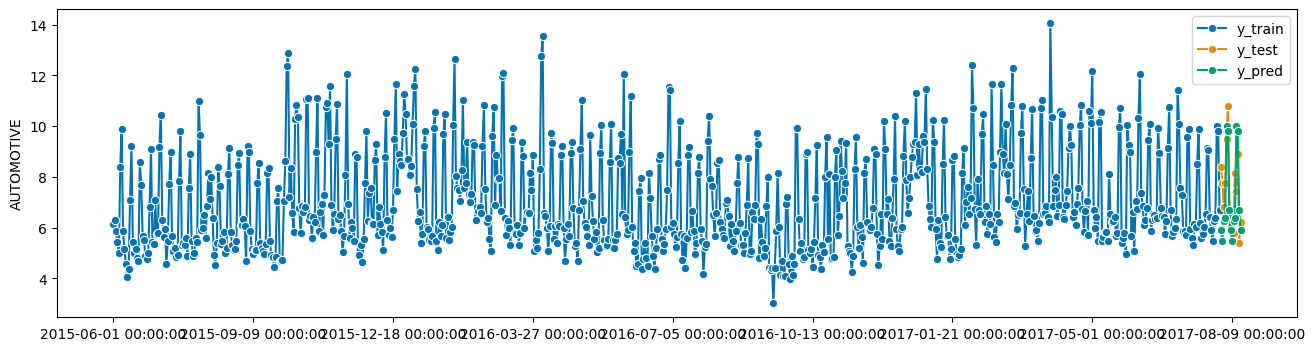

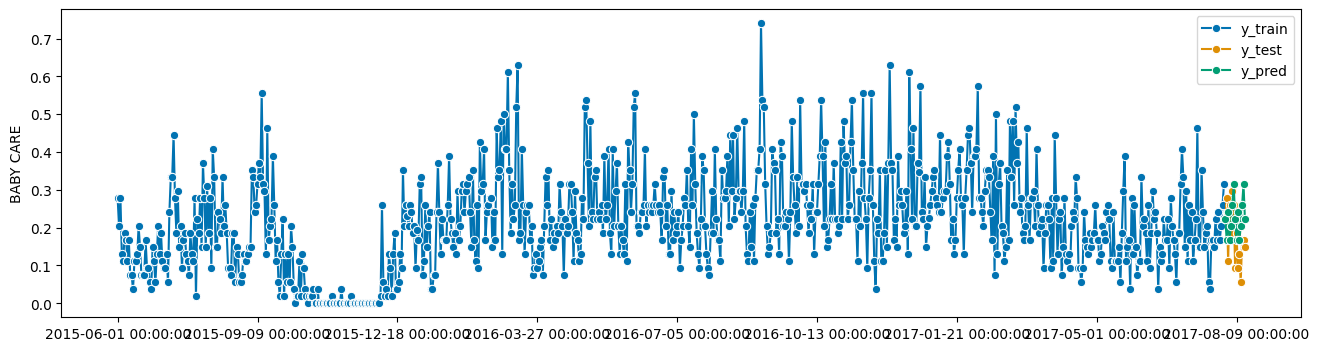

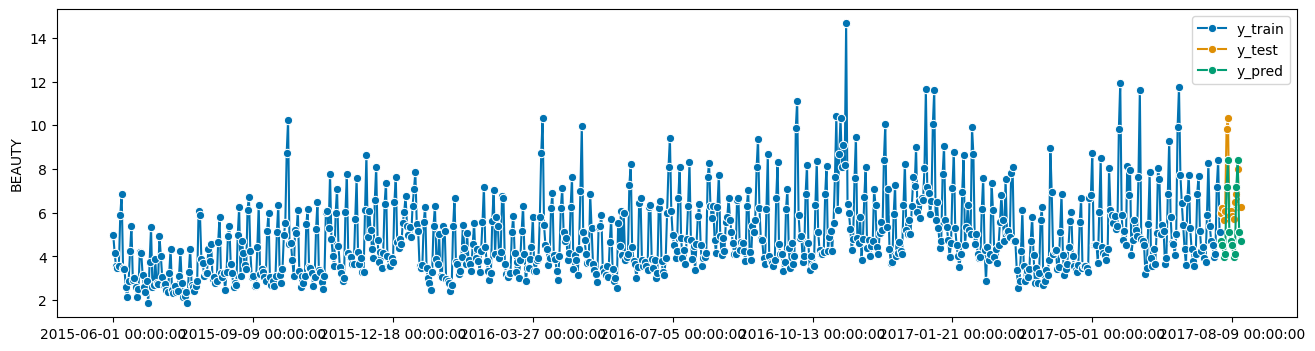

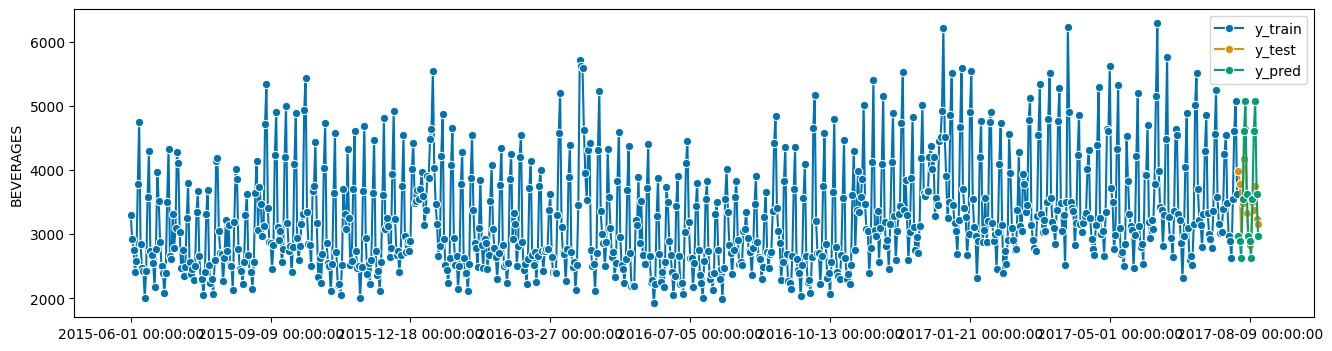

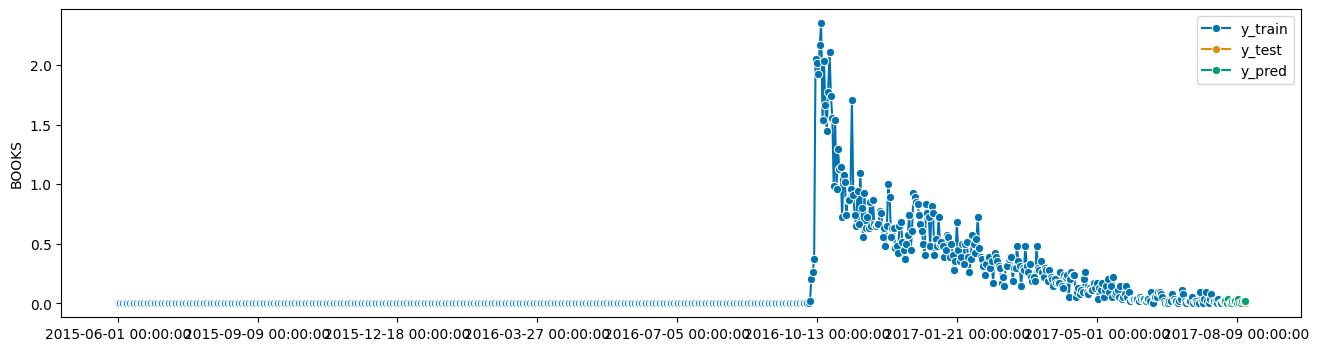

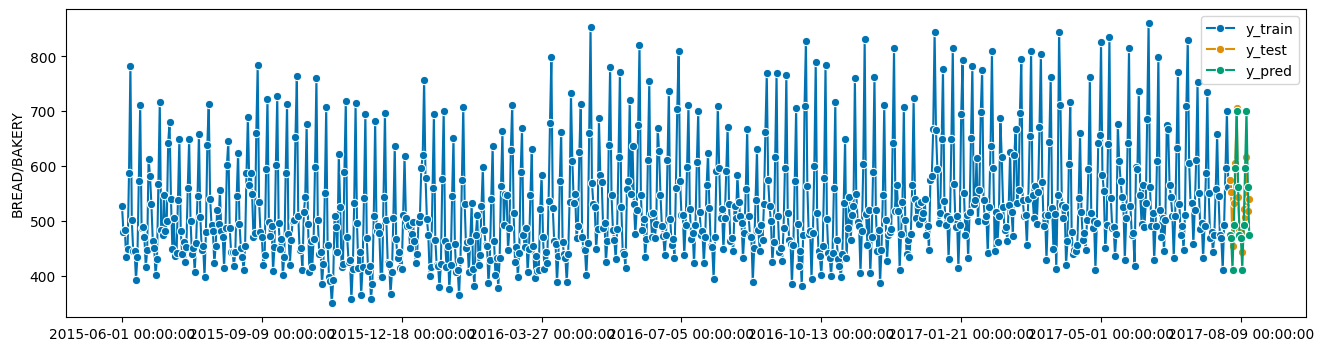

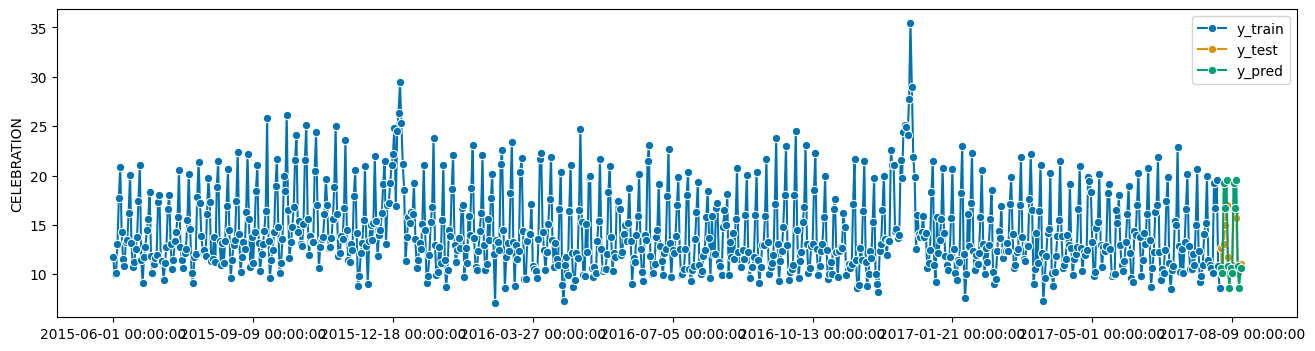

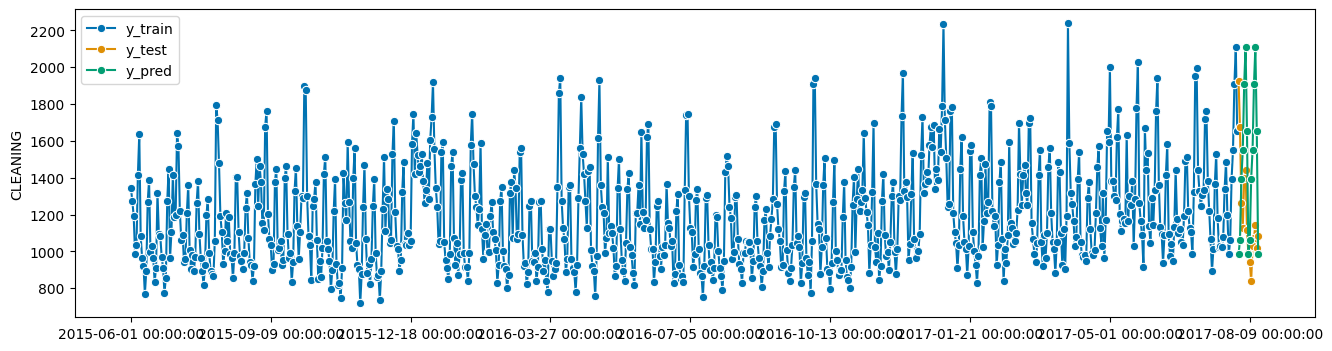

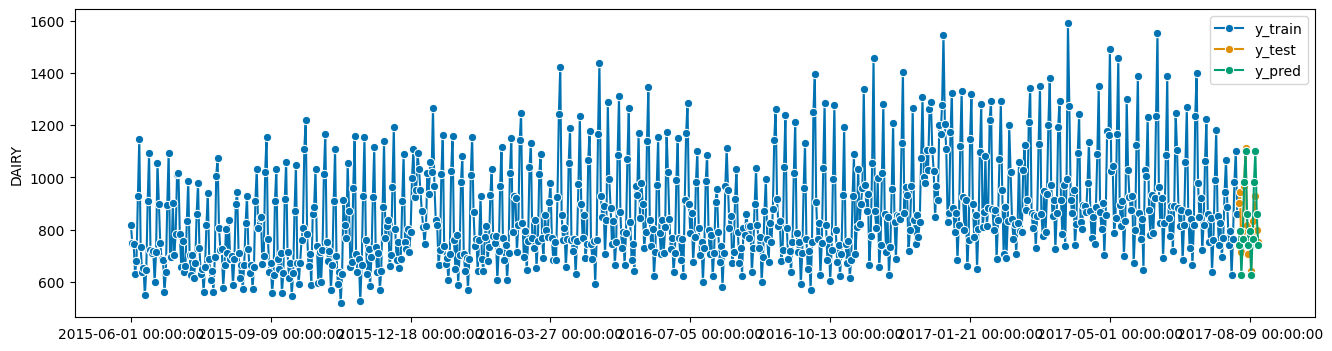

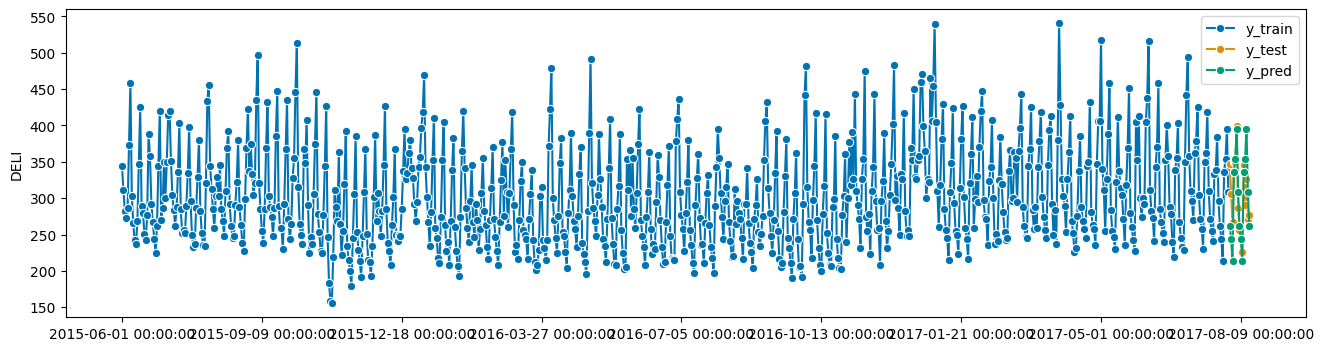

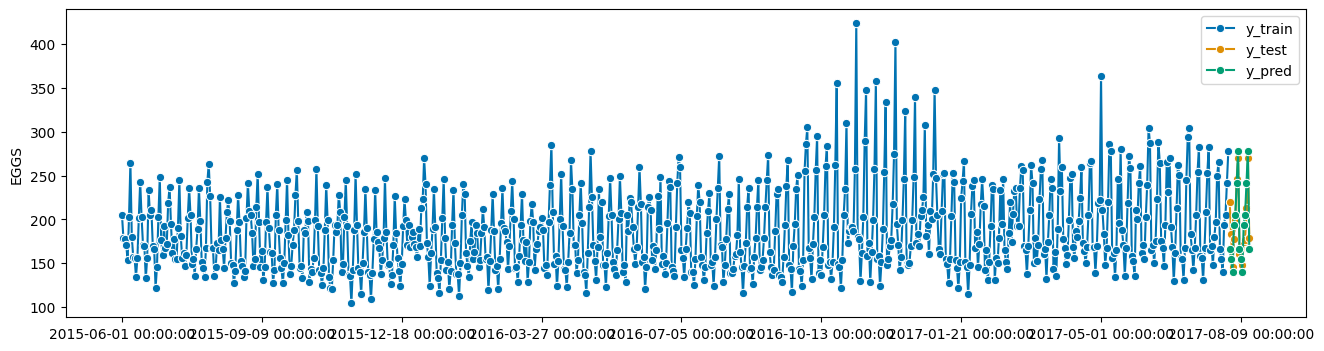

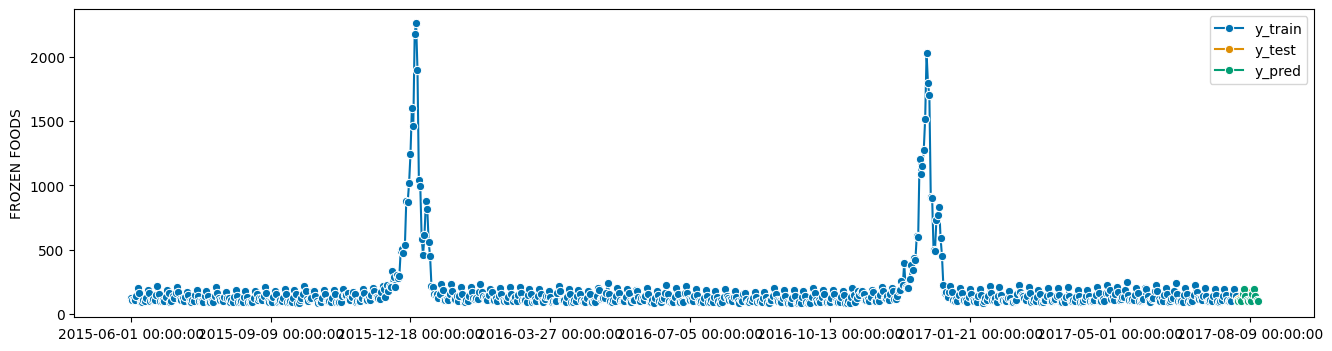

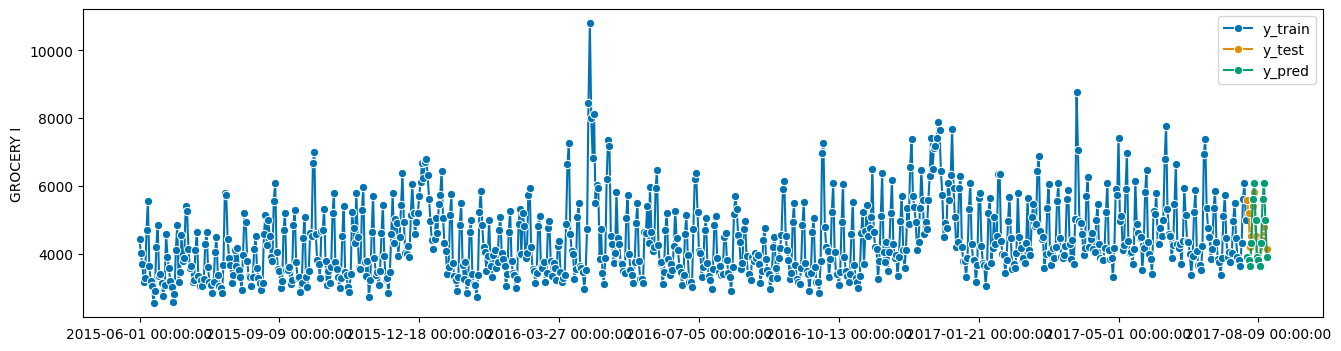

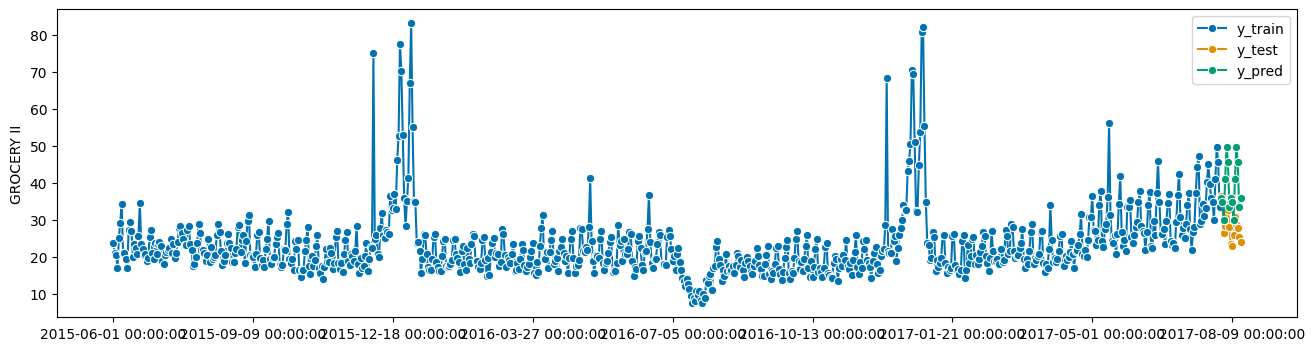

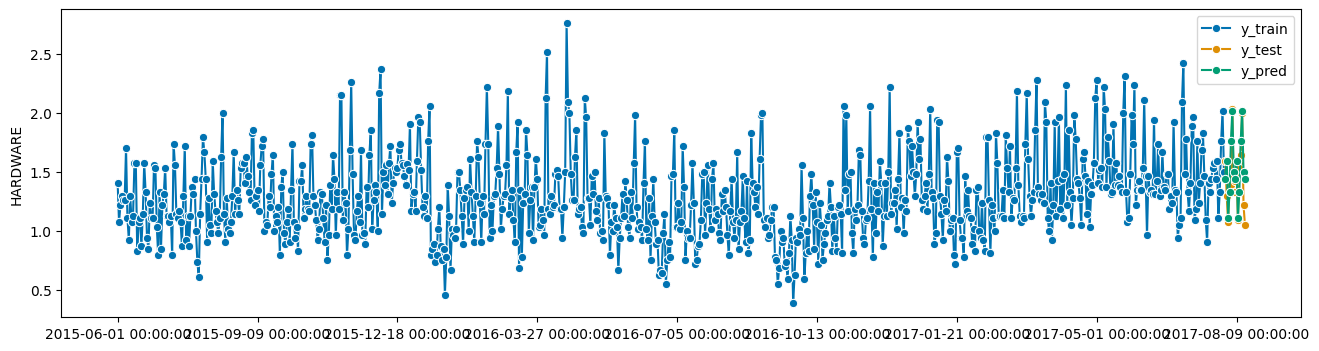

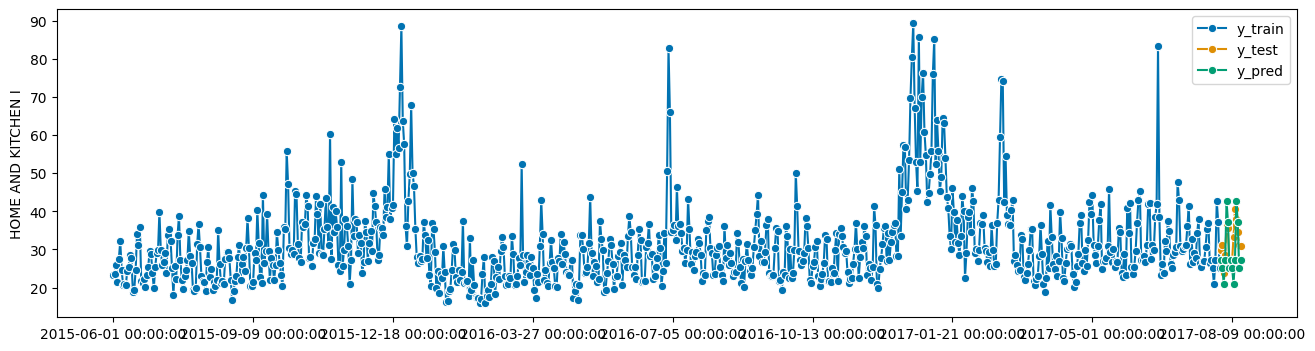

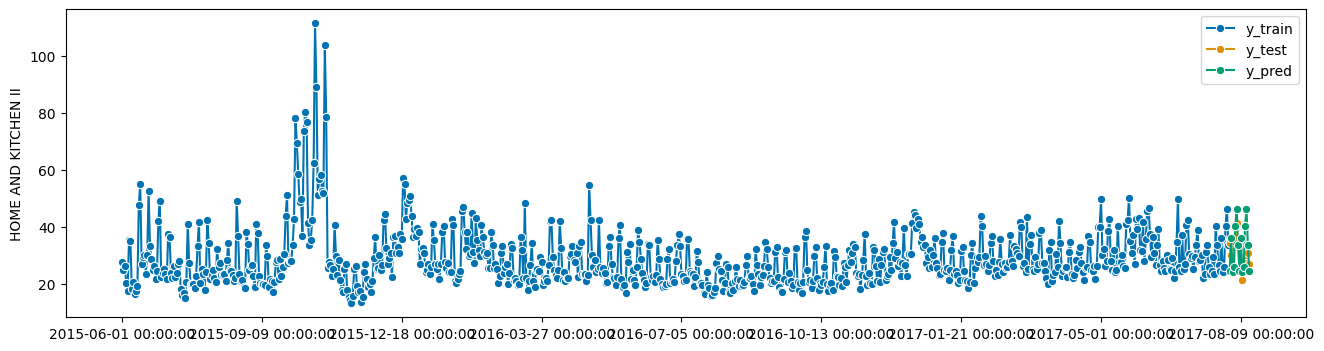

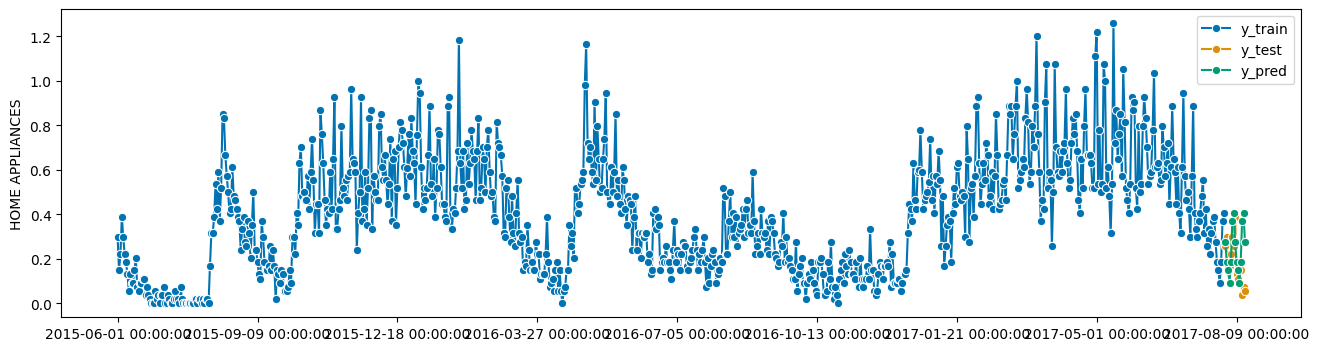

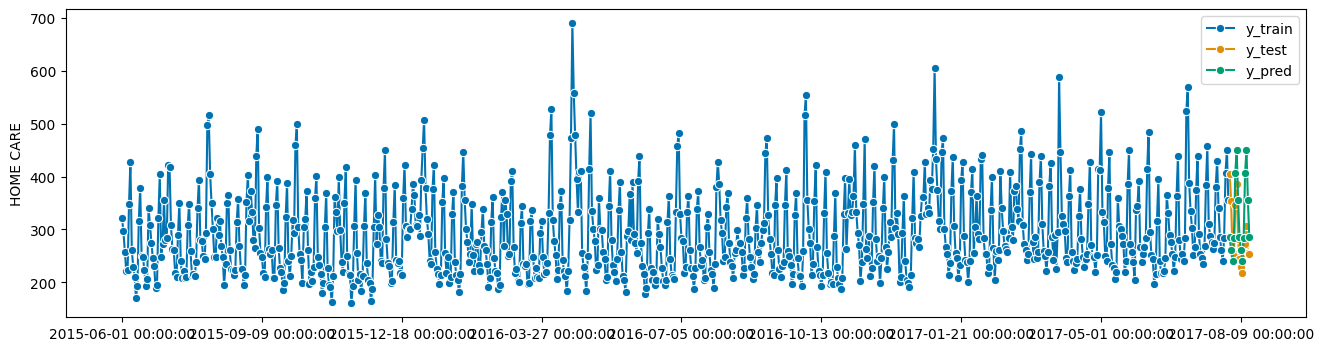

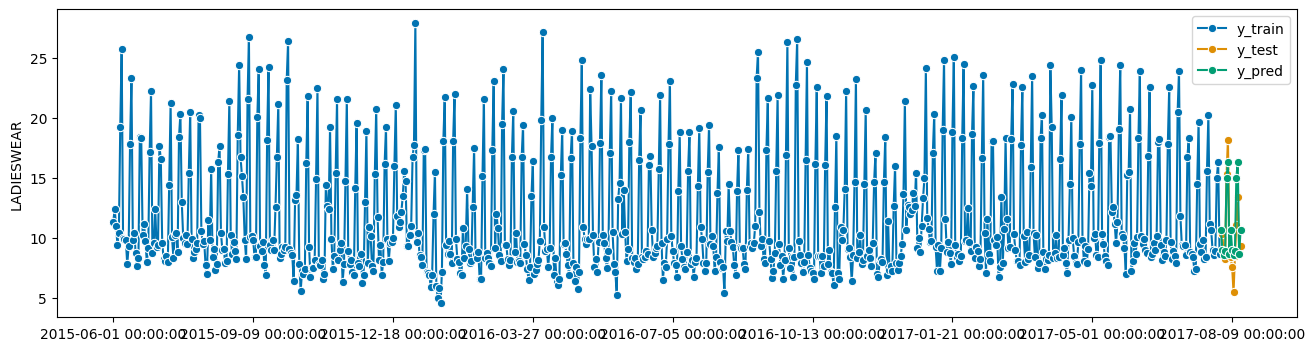

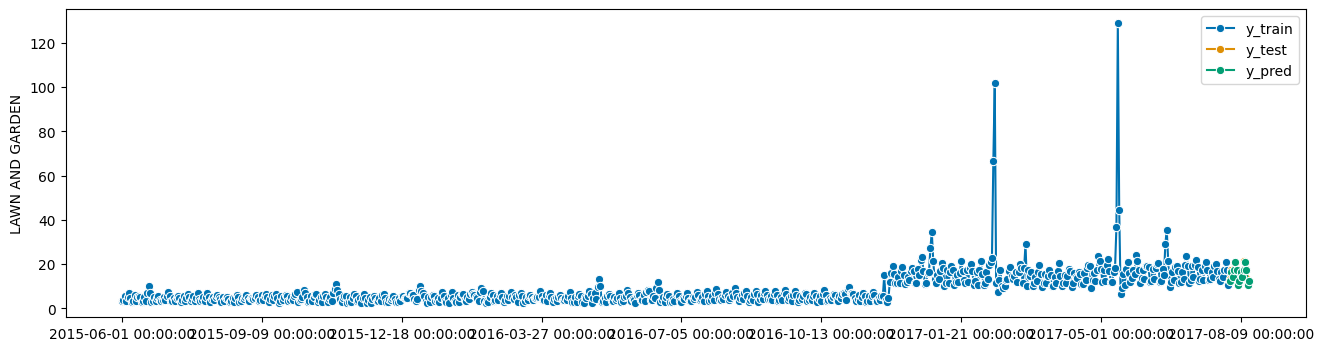

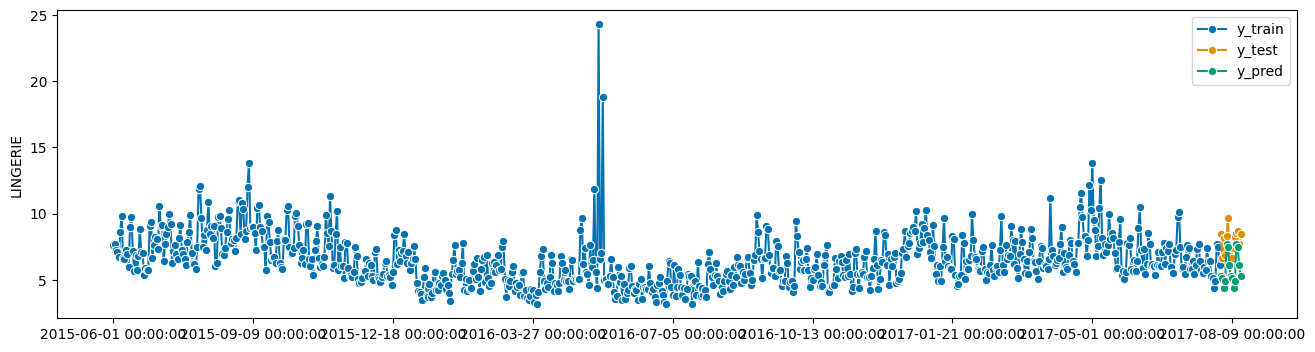

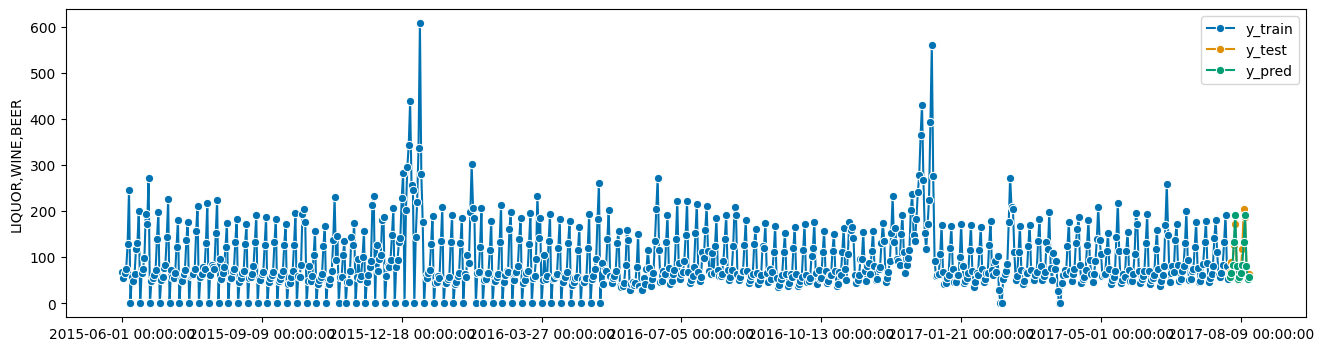

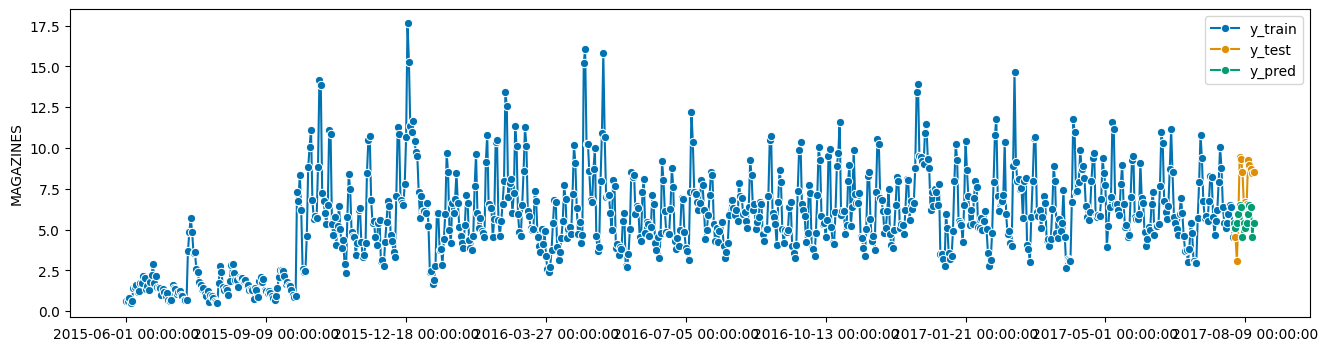

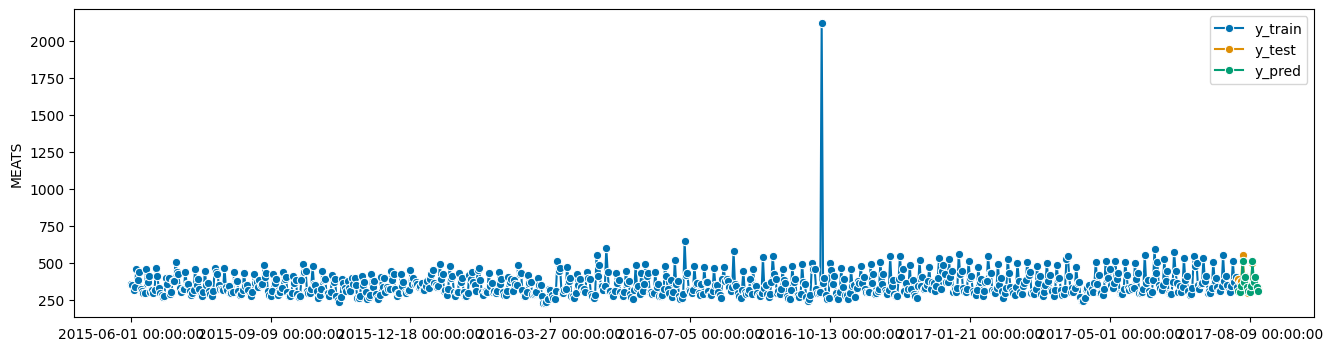

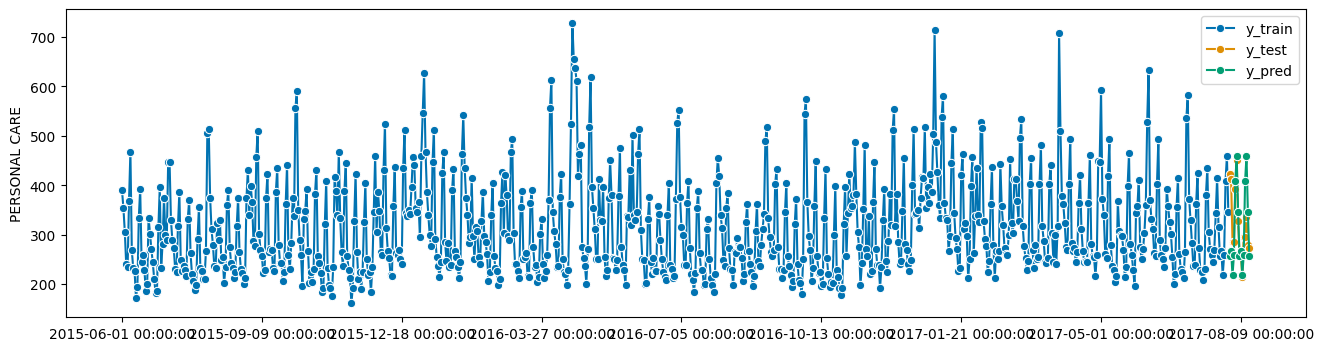

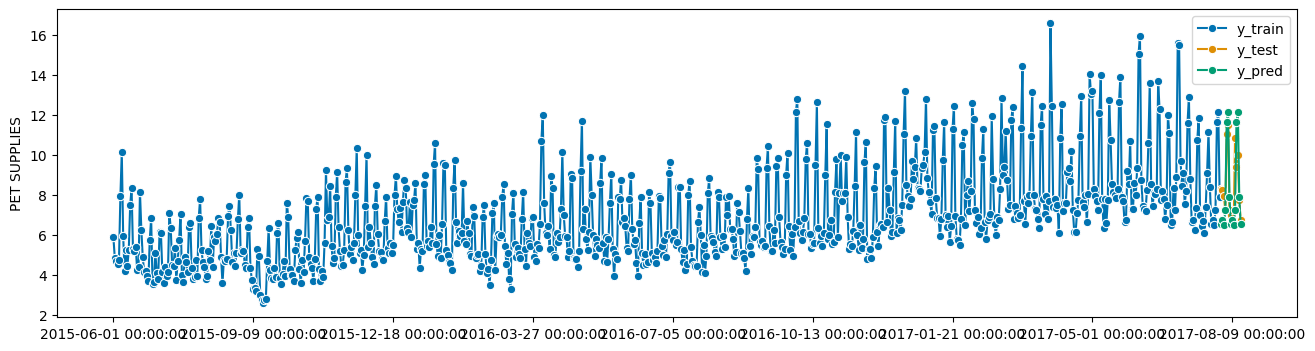

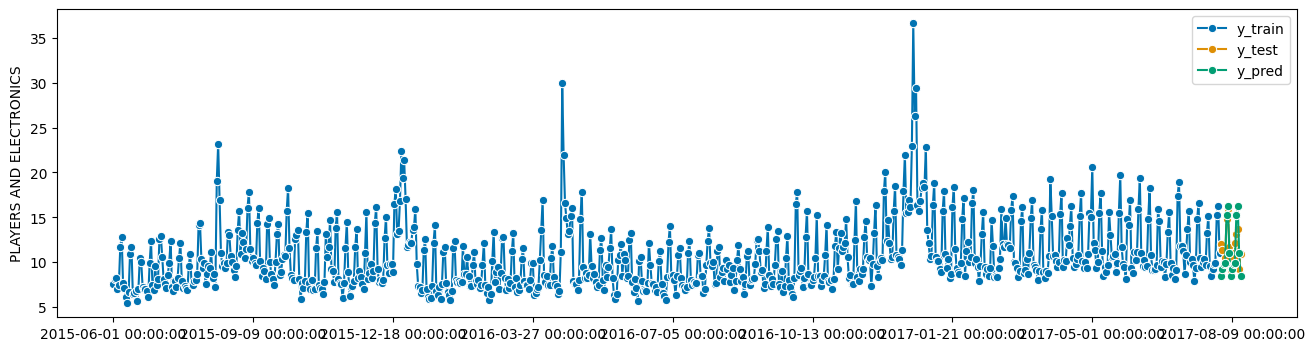

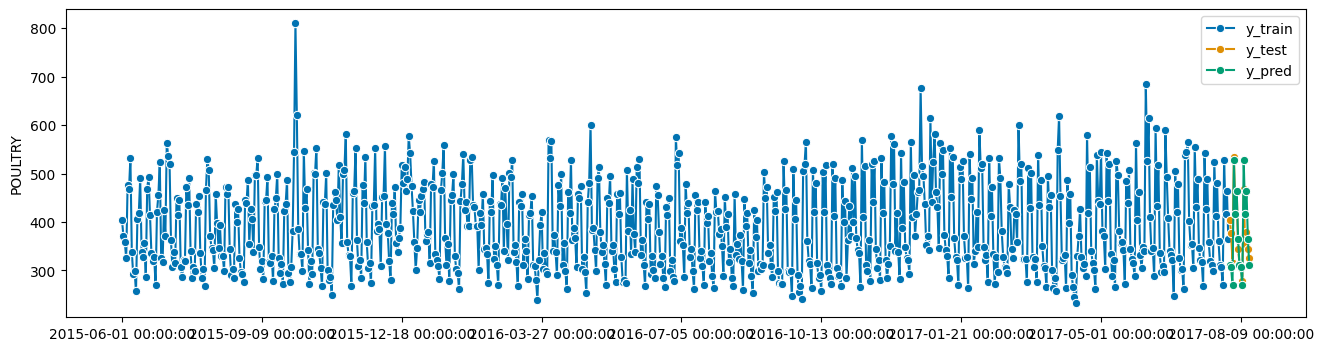

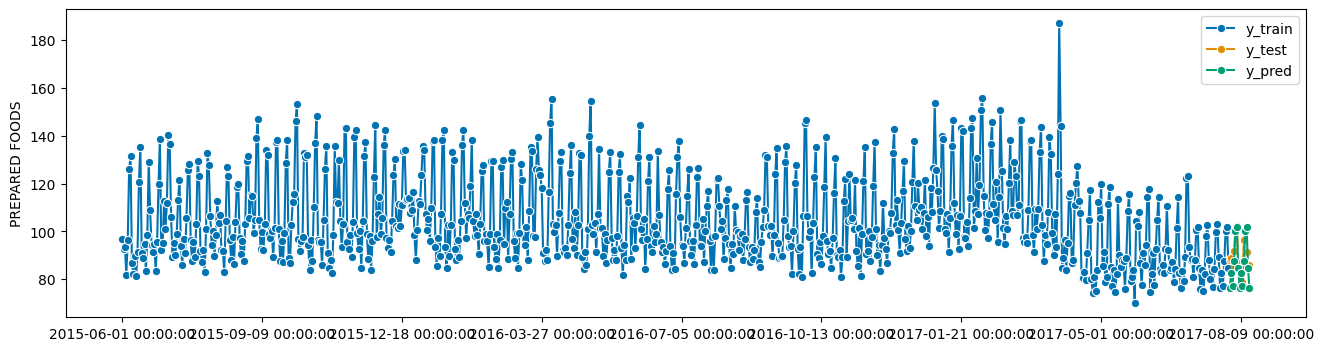

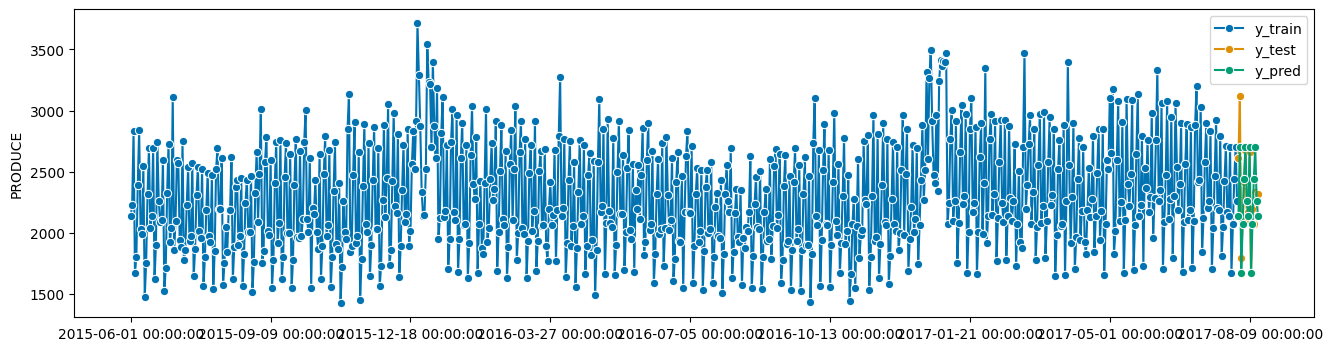

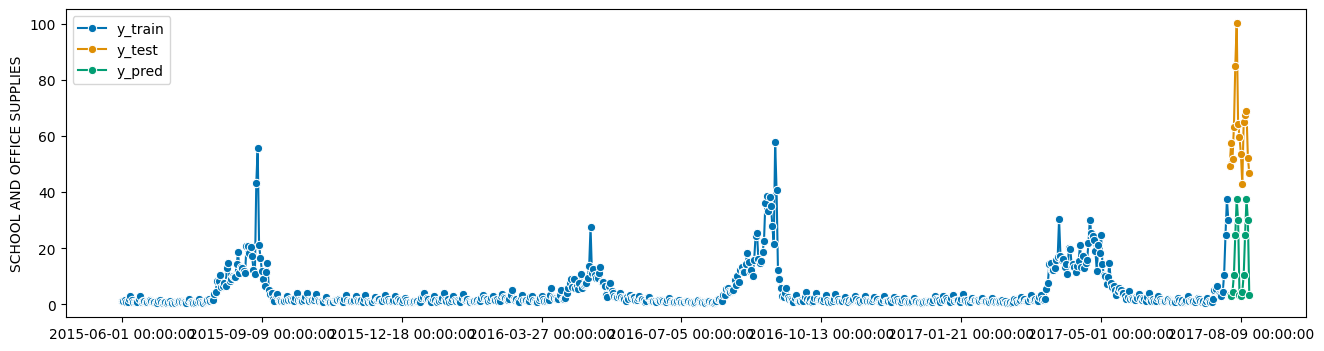

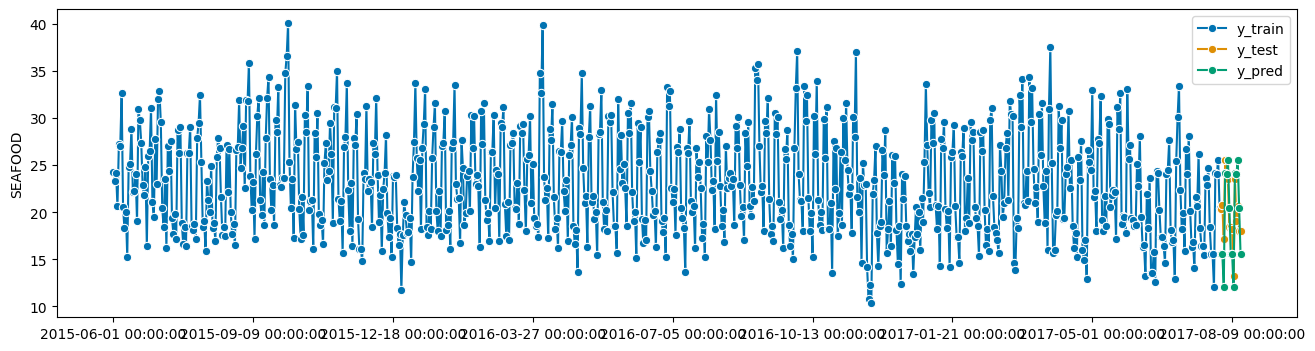

In [6]:
from sktime.performance_metrics.forecasting import MeanSquaredError

rmse = MeanSquaredError(square_root=True)

for col in y_train.columns:
    plot_series(y_train[col], y_test[col], y_pred[col], labels=['y_train', 'y_test', 'y_pred'])
    print('RMSE for {}:    {}'.format(col, rmse(y_test[col], y_pred[col])))
print('Overall RMSE {}'.format(rmse(y_test,y_pred)))

### Our first predictions
Here we have the first and simplest iteration of a predictor, using a NaiveForecaster with a seasonal period of 7 and a strategy of "last", which of means that it takes into account the previous 7 values when making its prediction. This parameter was chosen to capture some of the weekly seasonality we observed in the data.

##### Metric Selection
Here I have chosen **RMSE** or root mean squared error as the metric for evaluation. Advantages of this metric are the results are in the same unit as the target variable, which makes for good explainability downstream. It is also robust against 0 values, where something like MAPE or mean absolute percentage error is not. This could cause problems for us because some of the families like books for example, have 0 values in the ground truth for the test set.

##### Evaluating the results
We can see the results both visually and observe the RMSE. This will give us a baseline to evaluate our future iterations of modeling and prediction. **Since RMSE gives us a value in the same unit as our target variable, it represents an error in sales units, so lower will be better.**

##### Model Cross-Validation
It should be noted however, that in order to actually select the model that  generalizes the best to unseen data, we should implement a cross-validation strategy that will iteratively fit models and then test on portions of our training set. We can record the RMSE for each of these iterations and then take an average to see how well it does. While this is not a concept specific to time-series analysis, some special consideration needs to be applied to the splitting process when dealing with a time series.

The most important thing is we need to prevent data leakage, and we need to have consecutive dates in our training data.

We will be using a k-fold cv strategy that uses and expanding window strategy. This would look something like this for 5 folds (k=5)

+ signifies training data     * signifies test data  
fold 0 : ++++++++***  
fold 1 : ++++++++++++++++***  
fold 2 : ++++++++++++++++++++++++***  
fold 3 : ++++++++++++++++++++++++++++++++***  
fold 4 : ++++++++++++++++++++++++++++++++++++++++***  

In [162]:
from sklearn.model_selection import TimeSeriesSplit, KFold
from scipy.stats import t

#runs k fold cross validation and returns the mean of the error metric
def ts_model_cv(y_train, forecaster=None, cv=None, fh=None, metric=None, fit_fh=False):
   """
   performs cross validation for model evaluation

   Parameters:
      y_train    : the training data to use for model evaluation
      forecaster : an sktime forecaster object
      cv         : an sktime cross validation object
      fh         : an sktime forecast horizon object
      metric     : an sktime scoring metric
      fit_fh     : boolean value that determines whether to pass fh to fit method
   
   Returns:
      The mean of the scoring metric across all k folds of cross validation
   """
   folds = list(cv.split_loc(y_train))
   results = []
   for n in range(cv.get_n_splits(y_train)):
      train = y_train.loc[folds[n][0]]
      test = y_train.loc[folds[n][1]]
      train.index.freq = 'D'
      test.index.freq = 'D'
      if fit_fh:
         forecaster.fit(train, fh=fh)
      else:
         forecaster.fit(train)
      y_pred = forecaster.predict(fh)
      results.append(metric(np.expm1(test),np.expm1(y_pred)))
      print('Fold {}: {}'.format(n, metric(test,y_pred)))
   return np.mean(results)


#diebold-mariano statistical test for significance of prediction accuracy comparison
def diebold_mariano_test(forecast1, forecast2, actual):

    """
    Conduct the Diebold-Mariano test to compare the accuracy of two sets of time series forecasts.

    Parameters:
        forecast1 (array-like): The first set of forecasts
        forecast2 (array-like): The second set of forecasts
        actual (array-like): The actual values of the time series

    Returns:
        tuple: A tuple containing the DM test statistic and p-value
    """
    #compute residuals
    residuals1 = actual.values - forecast1.values
    residuals2 = actual.values - forecast2.values

    #compute loss differential series
    loss_differentials = (residuals1**2 - residuals2**2)
    mean = np.mean(loss_differentials)
    variance = np.var(loss_differentials)
    n = loss_differentials.shape[0]

    #compute autocovariance
    acvf = pd.Series(np.cumsum(loss_differentials - mean), name='acvf')
    standard_error = np.sqrt(variance / n)

    #compute test statistic and pvalue
    diebold_mariano_statistics = (acvf - mean) / standard_error
    pvalue = 1 - t.cdf(np.abs(diebold_mariano_statistics), n-1)
    pvalue = 2 * np.minimum(pvalue, 1-pvalue)

    return diebold_mariano_statistics, pvalue

##### Interpreting the Results
Here we can see that our RMSE across the 50 fold cross validation is a bit higher than the RMSE on our holdout test set. In real life we aren't going to have the ground truth values for the period we are interested in forecasting, so this cross validation performance will be a much more reliable metric to use to measure our models performance than comparing performance on the test set.

lets try a few more models

In [62]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import STLForecaster
from sktime.forecasting.compose import DirRecTimeSeriesRegressionForecaster, make_reduction
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sktime.forecasting.model_selection import ExpandingWindowSplitter

model_results = {}
fh = ForecastingHorizon(np.arange(1,16))
cv = ExpandingWindowSplitter(fh=fh, initial_window=42, step_length=15)
metric = MeanSquaredError(square_root=True)

models = [
        #NaiveForecaster(strategy='last', sp=7),
        #ExponentialSmoothing(trend='add', seasonal='add', sp=7),
        #make_reduction(LGBMRegressor(max_depth=6, n_estimators=20), window_length=13),
        #make_reduction(XGBRegressor(max_depth=6, n_estimators=20), window_length=13),
        #make_reduction(LGBMRegressor(max_depth=7, n_estimators=52), window_length=20),
        #make_reduction(XGBRegressor(max_depth=7, n_estimators=52), window_length=20),
        #make_reduction(LGBMRegressor(max_depth=5, n_estimators=29), window_length=20),
        #make_reduction(LGBMRegressor(max_depth=7, n_estimators=24), window_length=17),
        #STLForecaster(seasonal=7, sp=7, trend=55, robust=True),
        STLForecaster(seasonal=29, sp=7, trend=67, robust=True)
]

for model in models:
    model_results[str(model)] = ts_model_cv(y_train_log1p, forecaster=model, cv=cv, fh=fh, metric=metric)


Fold 0: 0.13449048553108903
Fold 1: 0.189082357044529
Fold 2: 0.15896855175179006
Fold 3: 0.1589063116261402
Fold 4: 0.18404793988640053
Fold 5: 0.23800187132502187
Fold 6: 0.15648267620871573
Fold 7: 0.26325465953136135
Fold 8: 0.10896100333787913
Fold 9: 0.16642297775755194
Fold 10: 0.29452451262647444
Fold 11: 0.2573970190086738
Fold 12: 0.2865945447185773
Fold 13: 0.18810947950514995
Fold 14: 0.1477068919076056
Fold 15: 0.1353772094889417
Fold 16: 0.13957404559988584
Fold 17: 0.17046984596290768
Fold 18: 0.1907668399703173
Fold 19: 0.18705289938963482
Fold 20: 0.21945603082596066
Fold 21: 0.2338320921964671
Fold 22: 0.16769272371540647
Fold 23: 0.16723363404495575
Fold 24: 0.11290247430688526
Fold 25: 0.146744265065268
Fold 26: 0.19001300357695686
Fold 27: 0.15703271681501388
Fold 28: 0.1533284098079394
Fold 29: 0.246640661074399
Fold 30: 0.13585718429942592
Fold 31: 0.1799024987287439
Fold 32: 0.1407799987308632
Fold 33: 0.1352930582414713
Fold 34: 0.20339084858066753
Fold 35: 0.3

##### Interpreting CV results
We can see that from trying a few different models and experiementing with a few hyperparameters for the STL forecaster, we have obtained a lower CV score with the STLforecaster using sp=7 and trend = 55. Recall that in the EDA we found that an sp of 28 smoothed the trend out enough to where enough of the seasonality was beiing caught in the decomposition. It turns out this is actually due to the trend hyperparameter, but by default it is set based off of the sp value. The sp value should be 7 to capture weekly seasonality, so the 55 value was calculated using the formula from the documentation based on the sp=28 value we used during decomposition.

We can also see when we check the rmse vs our hold out test set, the performance is better than with the NaiveForecaster alone. There are many hyperparameters for STLForecaster we could continue to tune, such as using different forecasters within the process to forecast each individual componenet. We can also observe that a large source of error for both models was the huge surge in "SCHOOL AND OFFICE SUPPLIES" that occurred during the test set period.



In [22]:
#lets output these results to CSV to use in our dashboard
#y_pred.unstack().to_csv('STLForecaster_pred.csv', index_label=[0,1,2])

##### Model Optimization
Now that we have some models performance evaluated, lets work on tuning some of those models and see which ones give the best cv scores. We can use sktime's ForecastingRandomizedSearchCV to accomplish this task

In [95]:

from sktime.forecasting.model_selection import ForecastingRandomizedSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sklearn.ensemble import RandomForestRegressor
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from lightgbm import LGBMRegressor
from sktime.forecasting.trend import STLForecaster

tuned_params = {}

#rmse = MeanSquaredError(square_root=True)
#forecaster = STLForecaster(sp = 7, robust=True)
#nested_params = {"seasonal": list(range(7,33,2)),
#                 "trend" : list(range(15, 75, 2))}
forecaster = make_reduction(LGBMRegressor())
nested_params = {"window_length" : list(range(7,32)),
                 "estimator__max_depth" : list(range(5,16)),
                "estimator__n_estimators" : list(range(20,120))}


fh = ForecastingHorizon(np.arange(1,16), is_relative=True)
#cv = SlidingWindowSplitter(initial_window=60, window_length=30)
cv = ExpandingWindowSplitter(fh=fh, initial_window=42, step_length=15)
nrcv = ForecastingRandomizedSearchCV(forecaster=forecaster, strategy="refit", cv=cv, 
                                        param_distributions=nested_params, 
                                        n_iter=100, random_state=42, scoring=rmse,
                                        error_score='raise')
for col in y_train_log1p.columns:
    nrcv.fit(y_train_log1p[col])
    tuned_params[col] = nrcv.best_params_
    print('{} :  {}'.format(col, nrcv.best_params_))
    print('{} :  {}'.format(col, nrcv.best_score_))



AUTOMOTIVE :  {'window_length': 29, 'estimator__n_estimators': 29, 'estimator__max_depth': 6}
AUTOMOTIVE :  0.15298936167797353
BABY CARE :  {'window_length': 15, 'estimator__n_estimators': 29, 'estimator__max_depth': 9}
BABY CARE :  0.08423715616967752
BEAUTY :  {'window_length': 28, 'estimator__n_estimators': 60, 'estimator__max_depth': 5}
BEAUTY :  0.1738061214230093
BEVERAGES :  {'window_length': 16, 'estimator__n_estimators': 71, 'estimator__max_depth': 9}
BEVERAGES :  0.14494786208317043
BOOKS :  {'window_length': 25, 'estimator__n_estimators': 22, 'estimator__max_depth': 12}
BOOKS :  0.07158133463704272
BREAD/BAKERY :  {'window_length': 29, 'estimator__n_estimators': 91, 'estimator__max_depth': 6}
BREAD/BAKERY :  0.09939267151130265
CELEBRATION :  {'window_length': 15, 'estimator__n_estimators': 46, 'estimator__max_depth': 15}
CELEBRATION :  0.14534540575144145
CLEANING :  {'window_length': 30, 'estimator__n_estimators': 60, 'estimator__max_depth': 11}
CLEANING :  0.140860694703

In [127]:
#lets output the results to a csv to save these tuned parameters
#params = pd.DataFrame.from_dict(tuned_params)
#params.to_csv('LGBM_tuned_params.csv')

In [97]:
def cv_multivariate_params(y_train, params, cv=None, fh=None, metric=None, fit_fh=False):
    """
    Takes a dictionary of parameter dictionaries and iterates our CV function for each model

    Parameters:
        y_train : training data to use for model evaluation
        params  : dictionary with columns as keys and dictionaries of parameter : value pairs as columns
        cv      : sktime cv object
        fh      : sktime fh object
        metric  : sktime scoring metric object
        fit_fh  : whether to pass fh to fit function

    Returns:
        The mean of all models cv scores across all cv folds
    """
    cv_score = []
    print(y_train.index.freq)
    print(cv)
    print(fh)
    for col in y_train:
        regressor = LGBMRegressor(n_estimators=params[col]['estimator__n_estimators'],
                                  max_depth=params[col]['estimator__max_depth'])
        forecaster = make_reduction(regressor, window_length=params[col]['window_length'])
        cv_score.append(ts_model_cv(y_train[col], forecaster=forecaster, cv=cv, fh=fh, metric=metric, fit_fh=fit_fh))
    return np.mean(cv_score)



<Day>
ExpandingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', is_relative=True),
                        initial_window=42, step_length=15)
ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], dtype='int64', is_relative=True)
Fold 0: 0.21373290347360438
Fold 1: 0.2066732400371906
Fold 2: 0.12157875213773073
Fold 3: 0.1332166383130628
Fold 4: 0.07803869963173435
Fold 5: 0.2672488843398041
Fold 6: 0.1653150059569904
Fold 7: 0.18573764419049643
Fold 8: 0.12454314637686269
Fold 9: 0.09075348878100711
Fold 10: 0.1897320452418359
Fold 11: 0.1777326761967685
Fold 12: 0.28664167523133105
Fold 13: 0.16932266021348144
Fold 14: 0.13450692880317283
Fold 15: 0.22272094122257277
Fold 16: 0.08187575921738548
Fold 17: 0.17557754228618933
Fold 18: 0.08911193525520962
Fold 19: 0.08413454449487248
Fold 20: 0.08045134958877308
Fold 21: 0.21994857481700045
Fold 22: 0.19939335911927197
Fold 23: 0.1215394051172219
Fold 24: 0.1745120

In [ ]:
print(cv_multivariate_params(y_train_log1p, tuned_params, cv=cv, fh=fh, metric=rmse))

##### Results of model optimization
It looks like our best performing model after some tuning is an LGBM model using the sktime make_reduction wrapper. This achieved our lowest cv RMSE score so far of 69.3342. 

Lets see how it does on prediction of the holdout test set

In [112]:
y_pred_df = pd.DataFrame(index=y_test.index)
result = []
for col in y_train:
    regressor = LGBMRegressor(n_estimators=tuned_params[col]['estimator__n_estimators'],
                              max_depth=tuned_params[col]['estimator__max_depth'])
    forecaster = make_reduction(regressor, window_length=tuned_params[col]['window_length'])
    forecaster.fit(y_train_log1p[col])
    y_pred = forecaster.predict(fh)
    result.append(rmse(y_test[col], np.expm1(y_pred)))
    y_pred_df = pd.concat([y_pred_df, pd.DataFrame(np.expm1(y_pred), columns=[col])], axis=1)
print(np.mean(result))


68.62324729799685


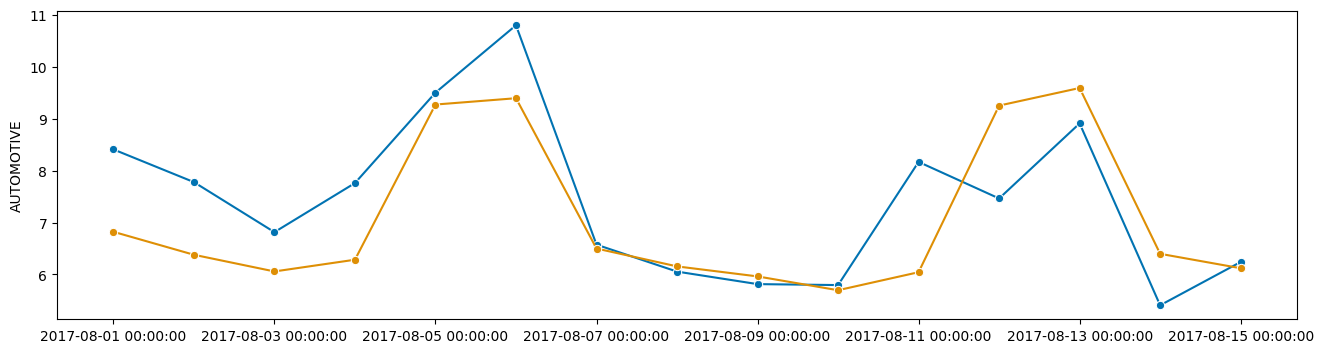

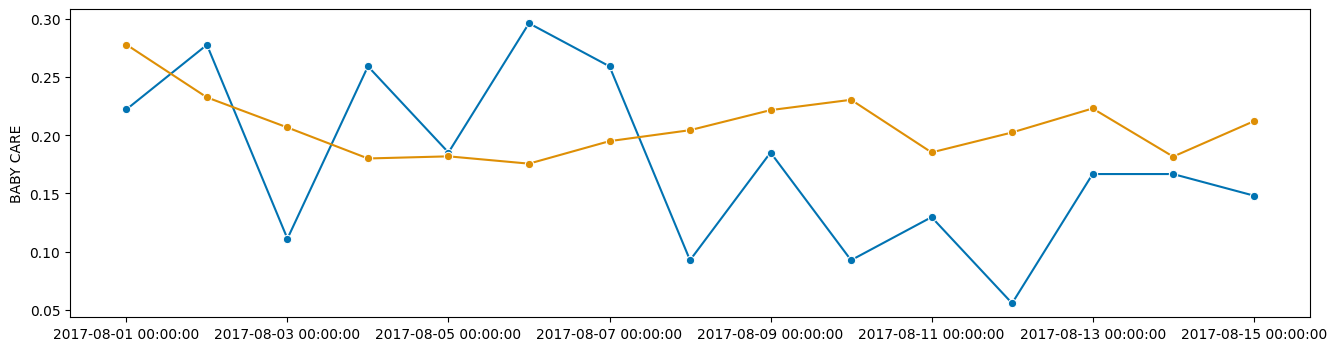

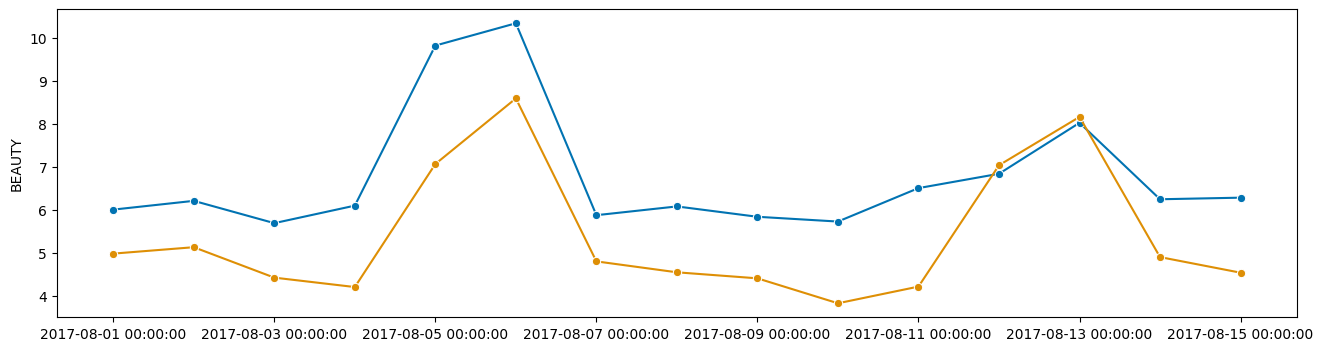

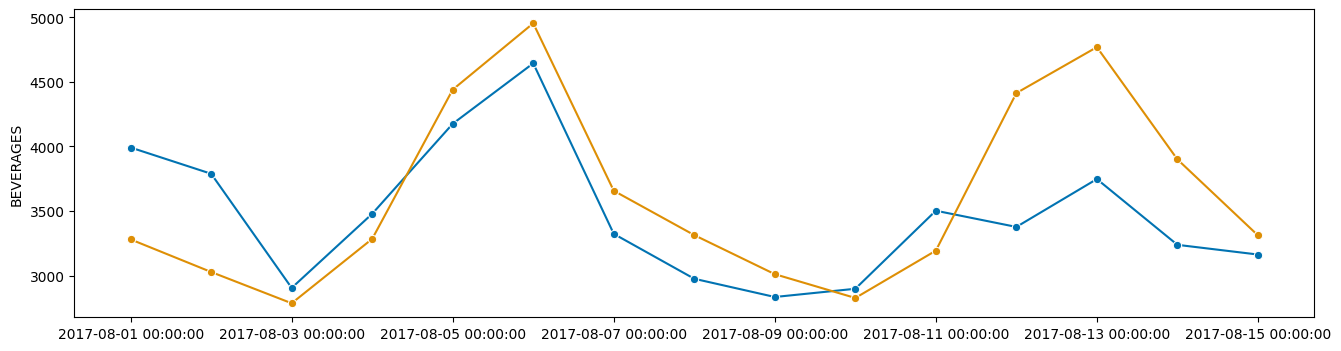

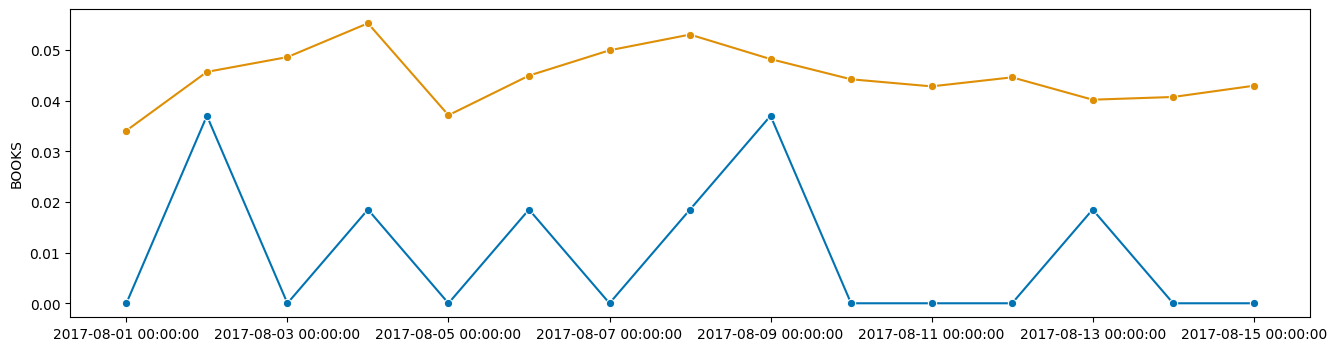

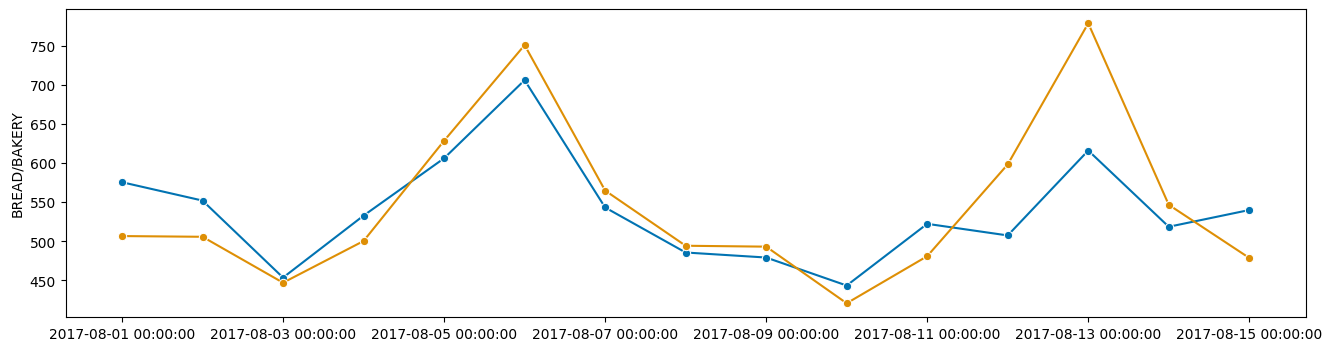

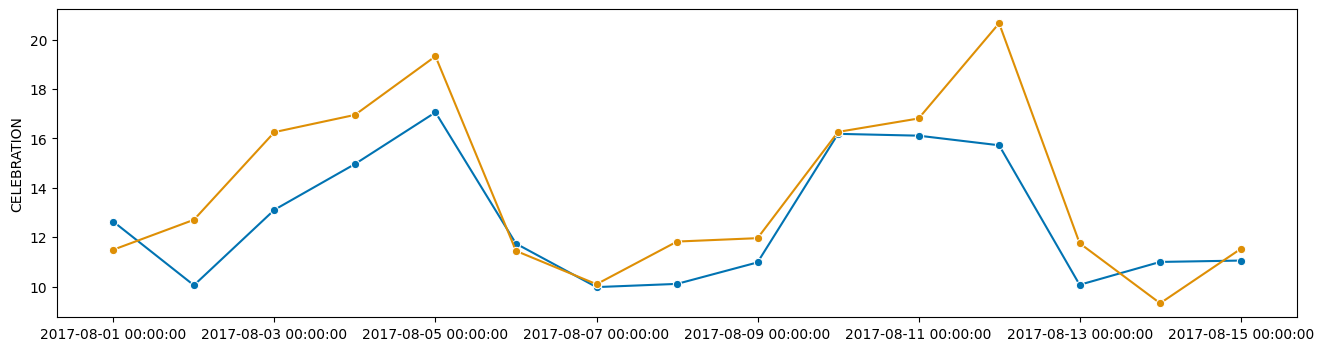

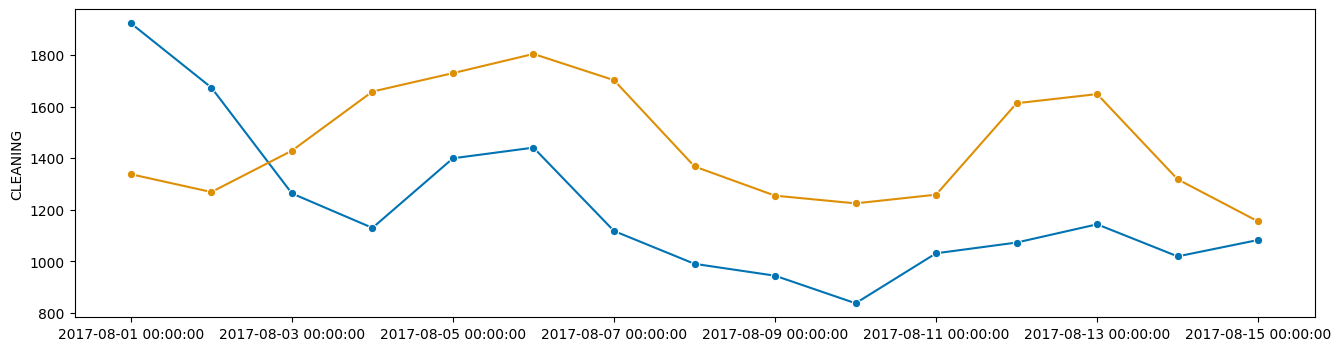

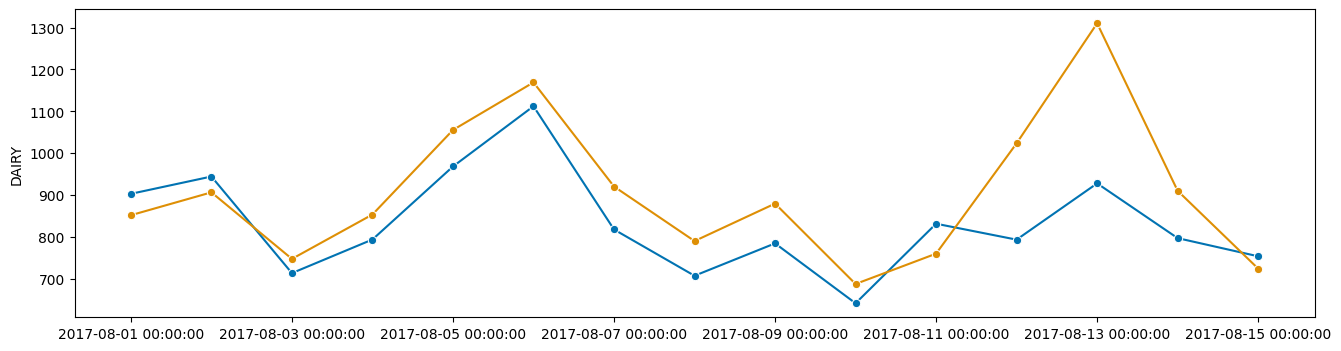

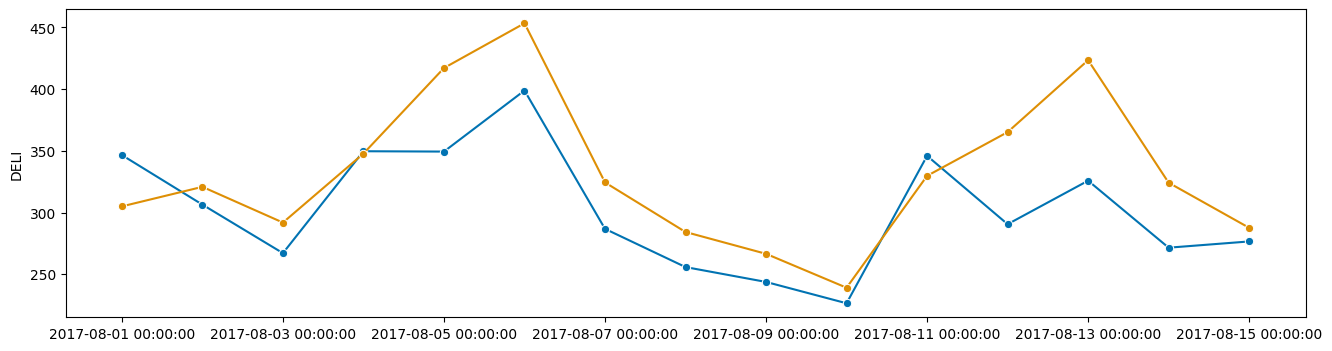

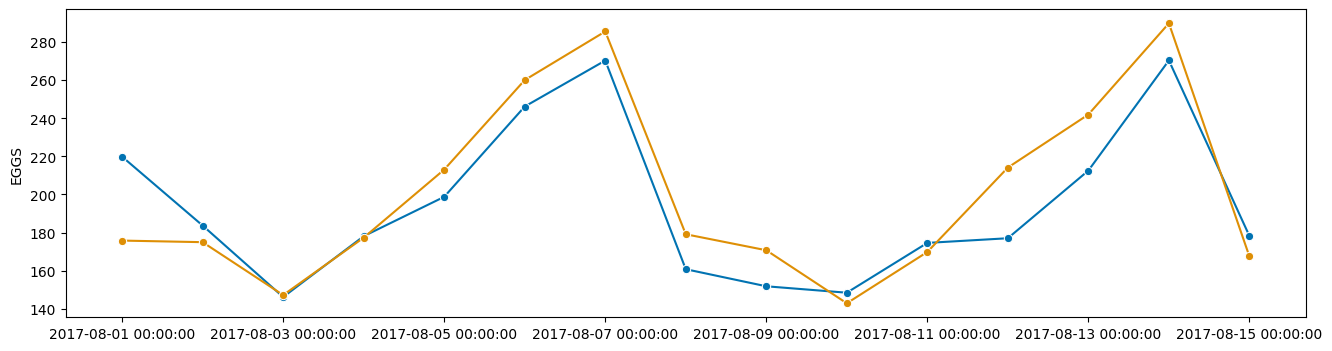

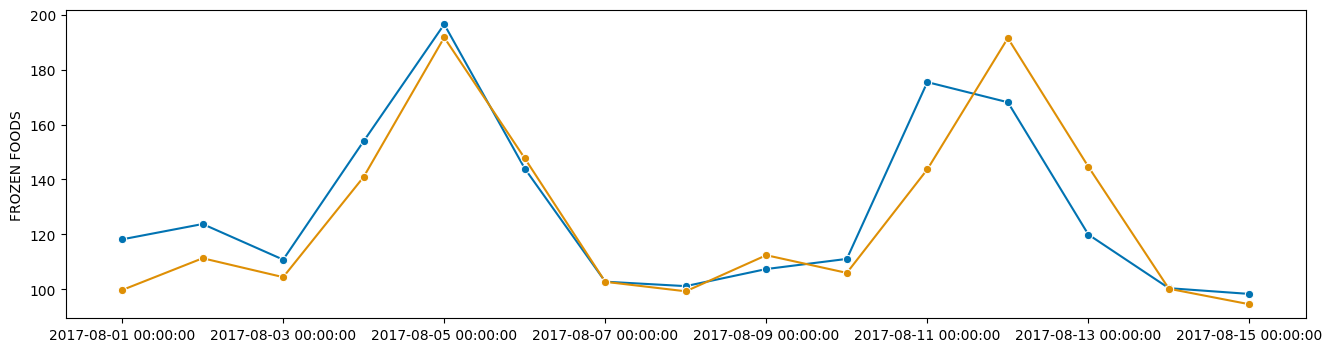

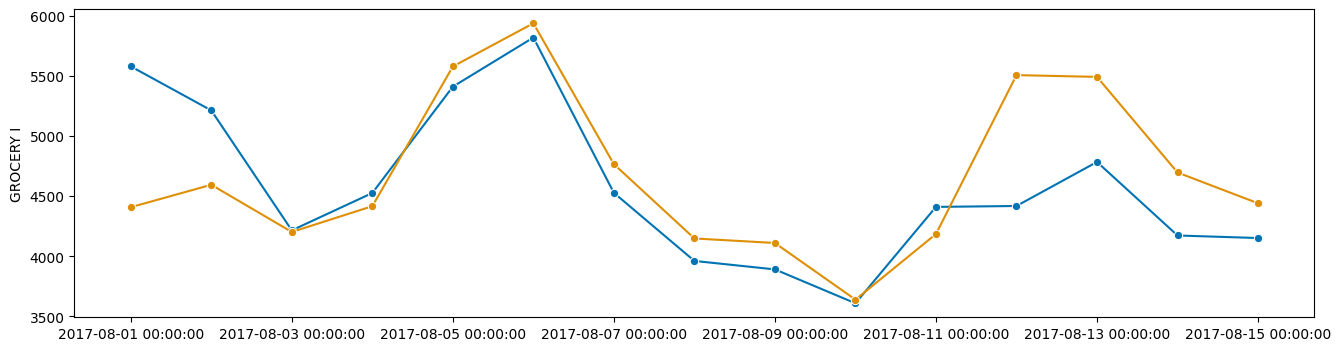

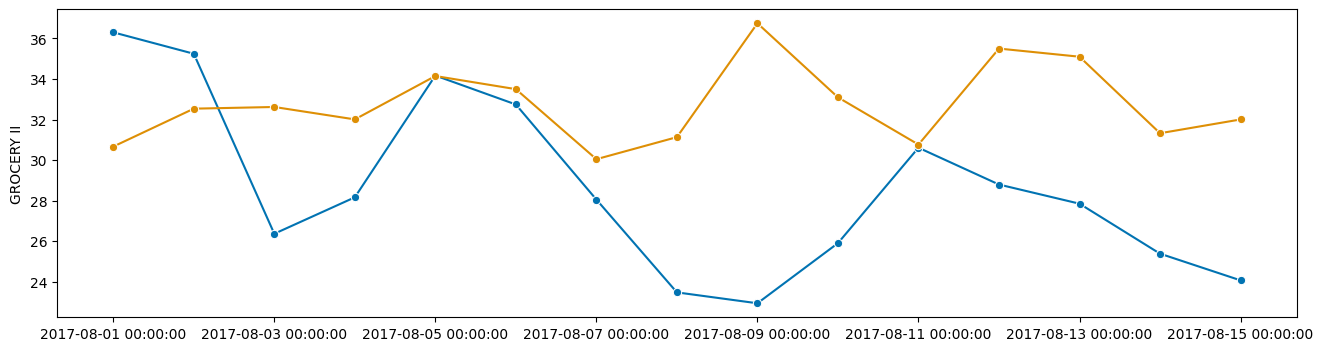

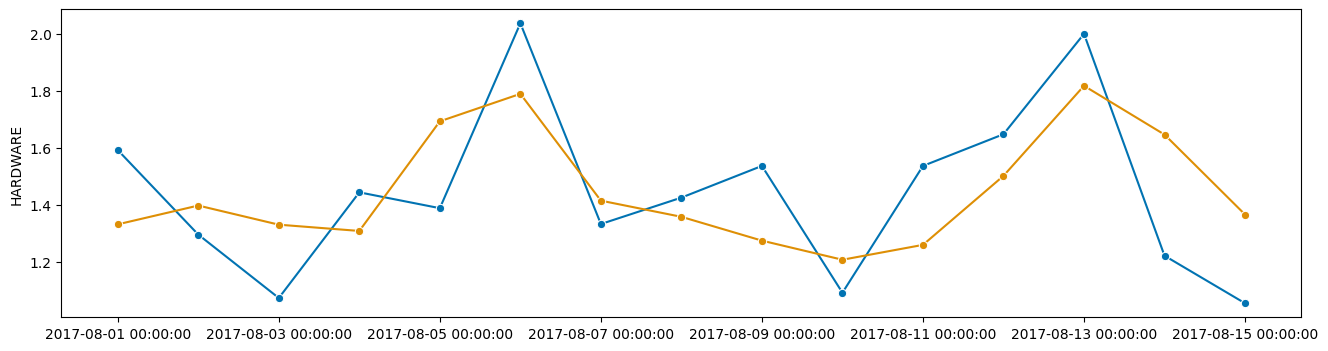

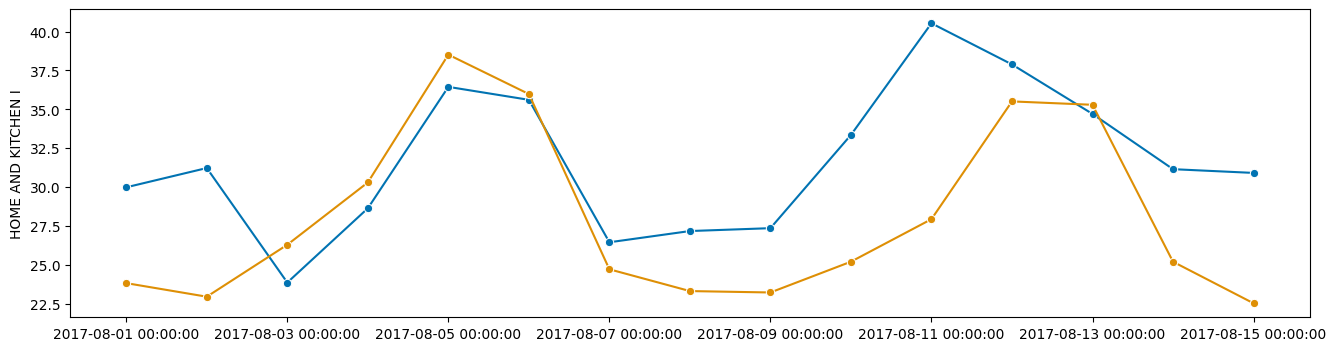

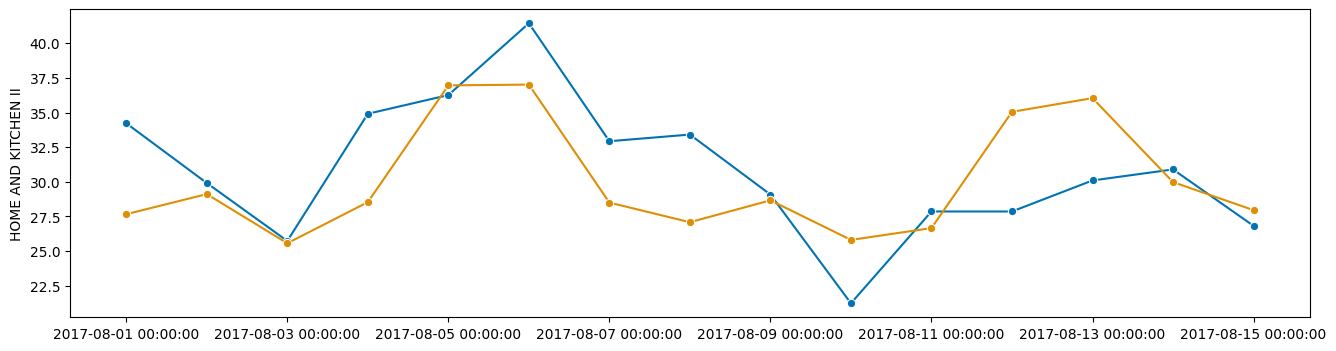

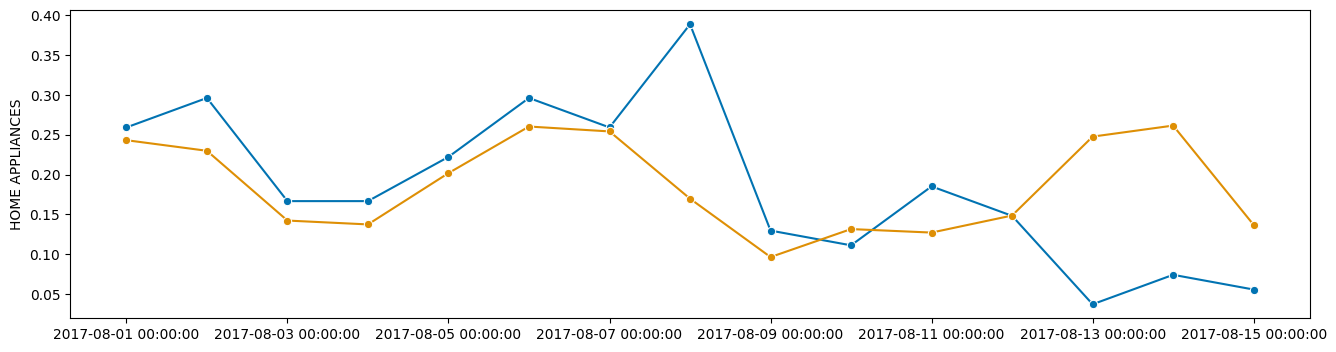

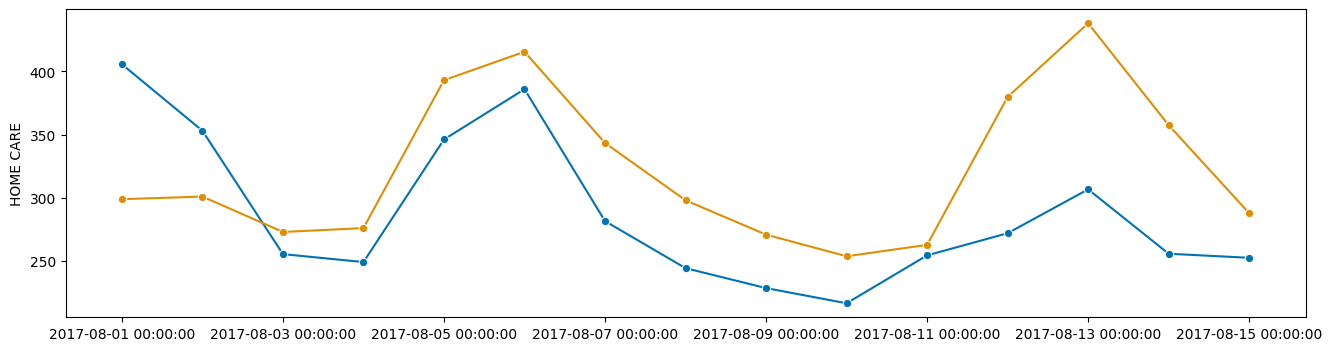

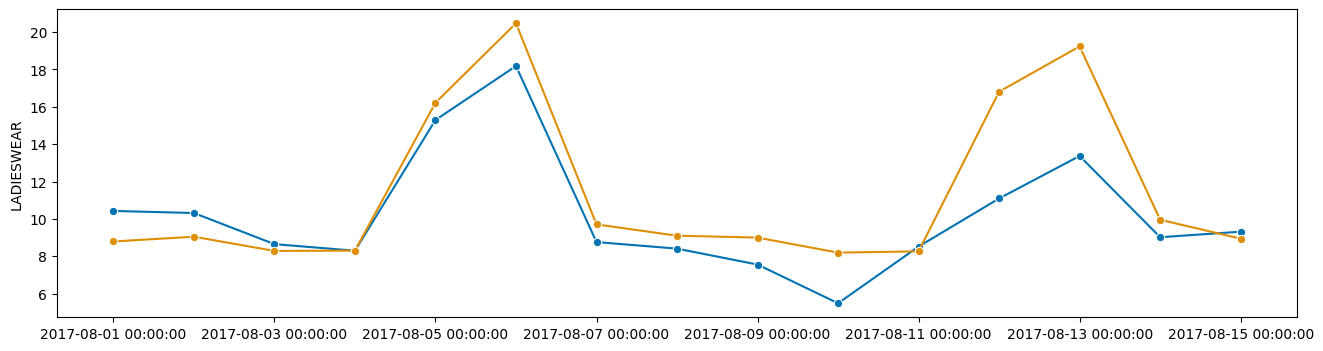

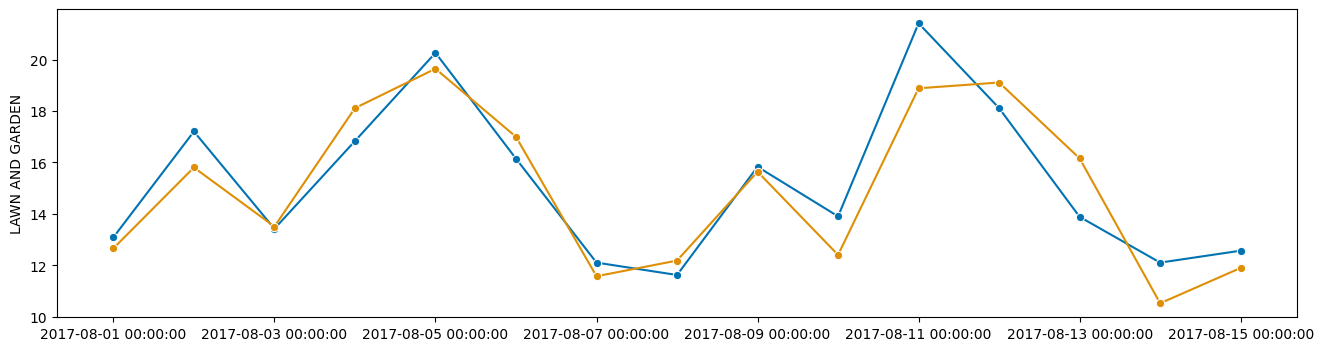

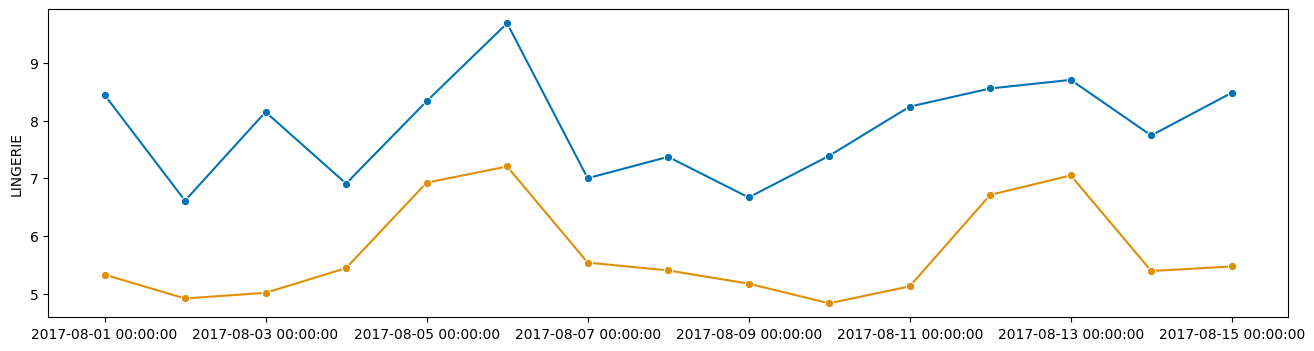

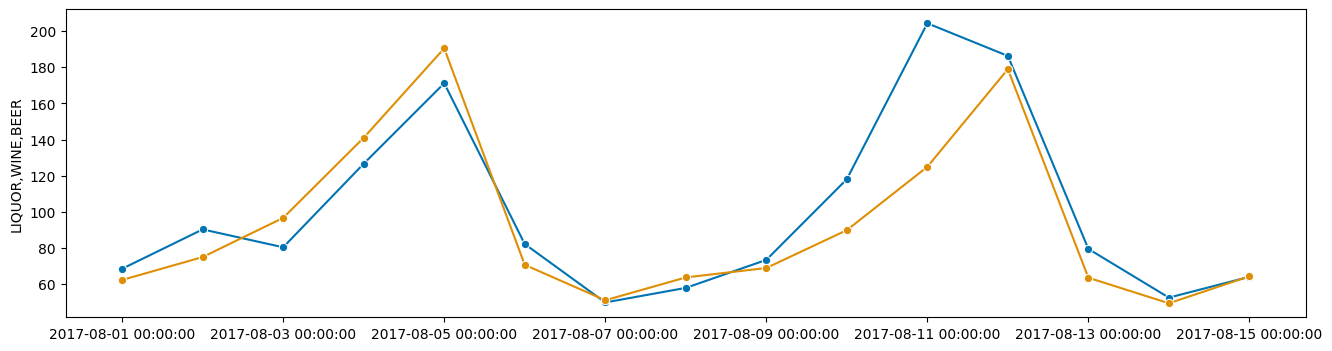

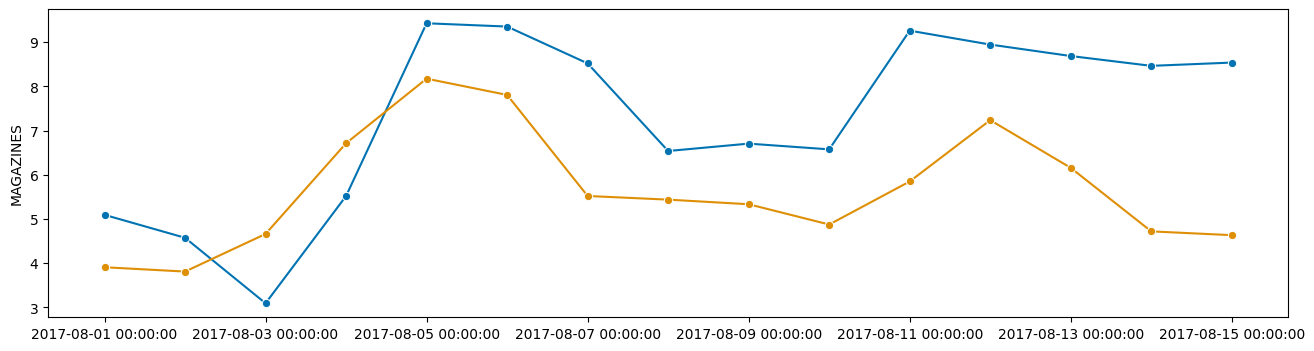

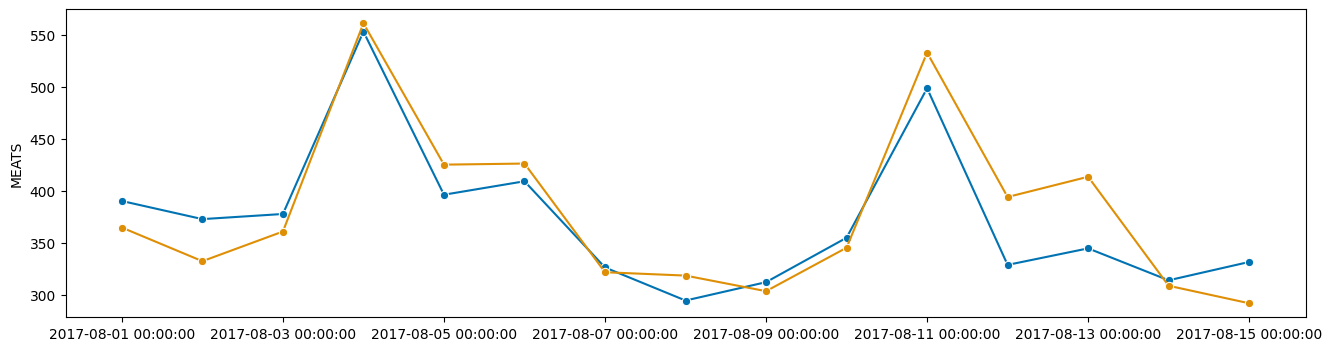

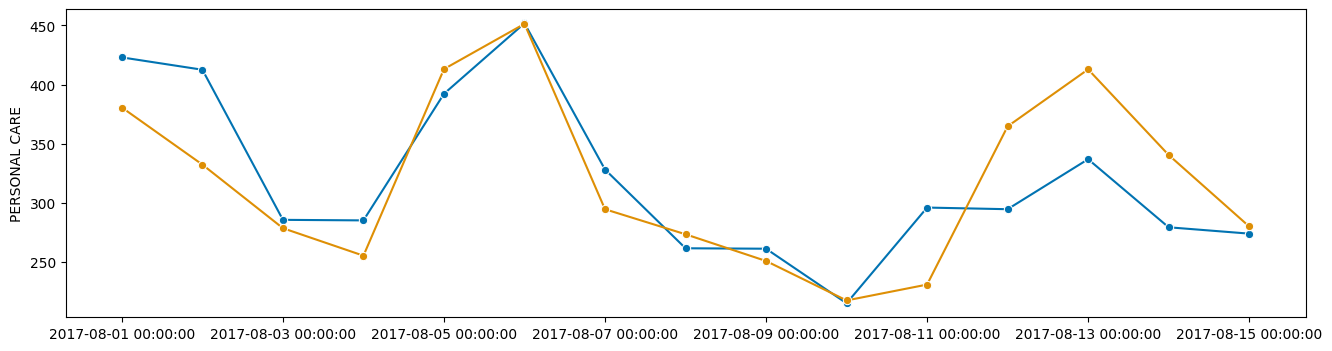

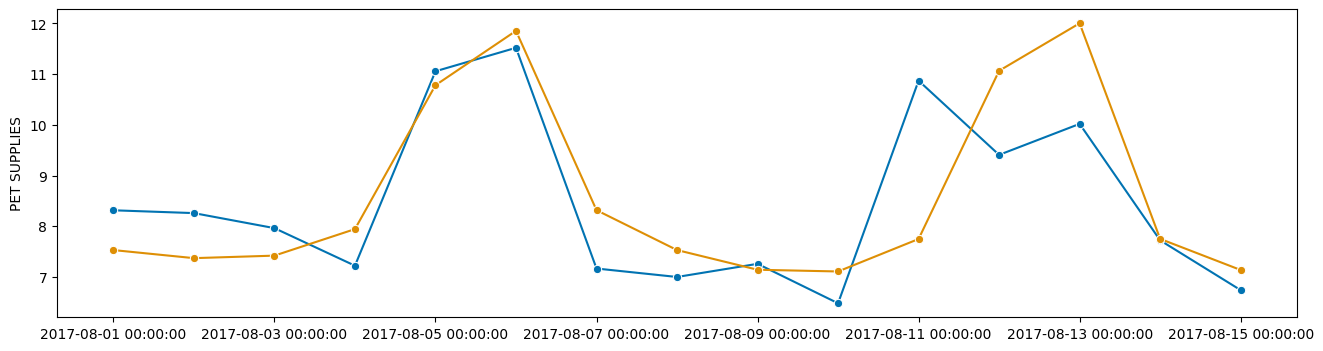

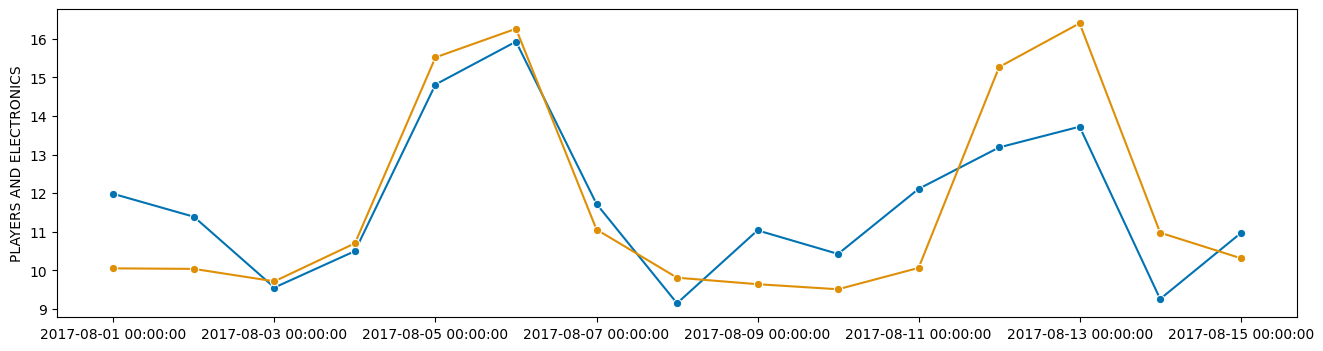

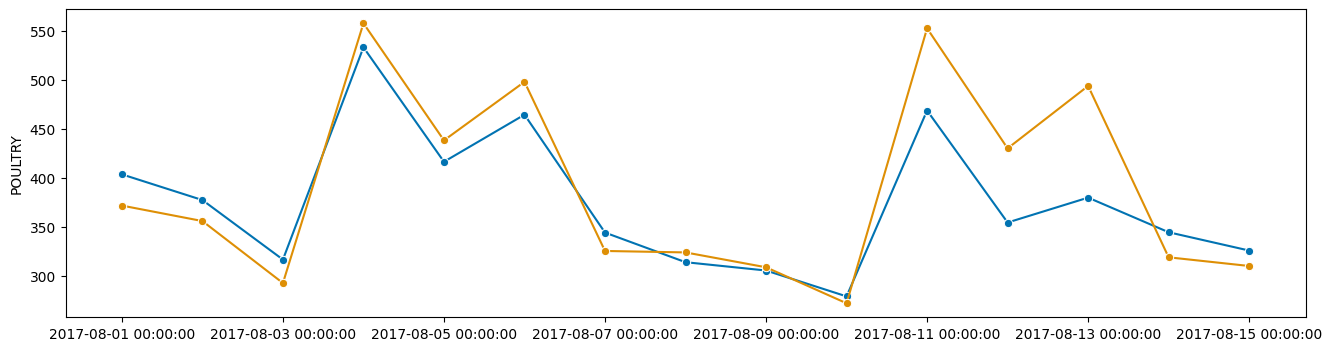

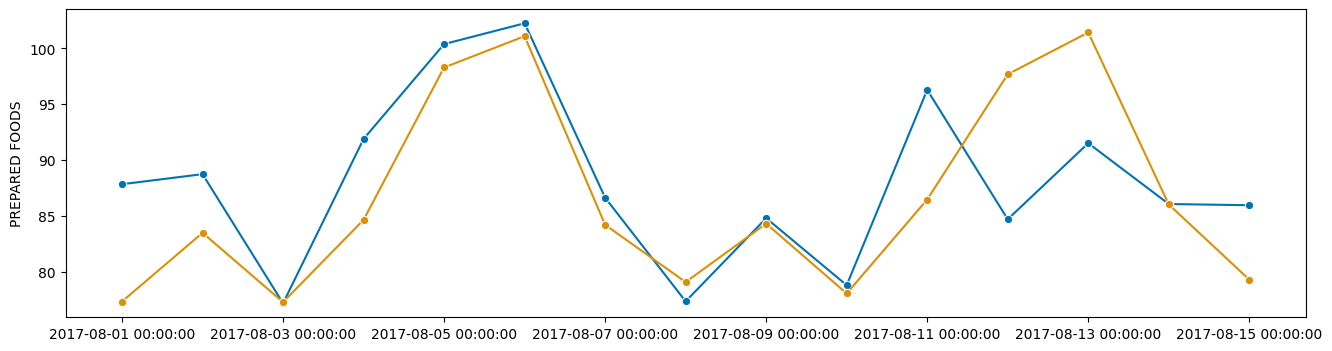

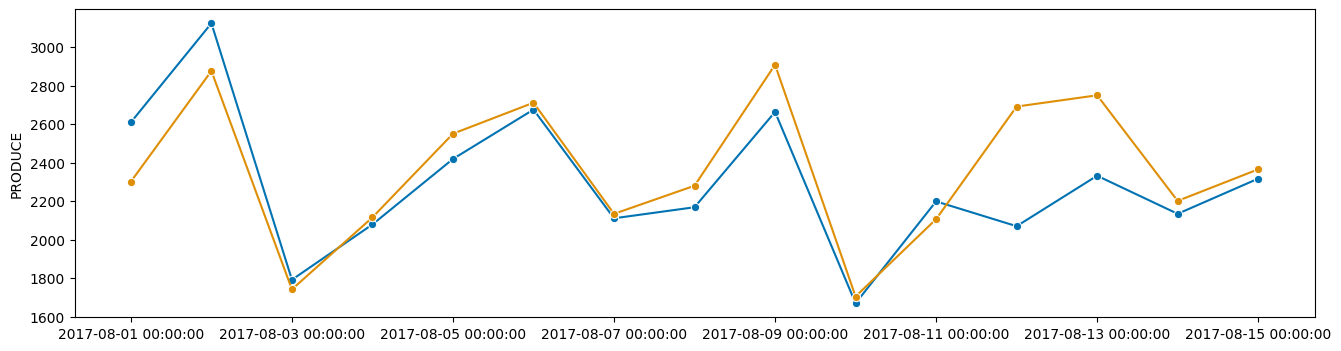

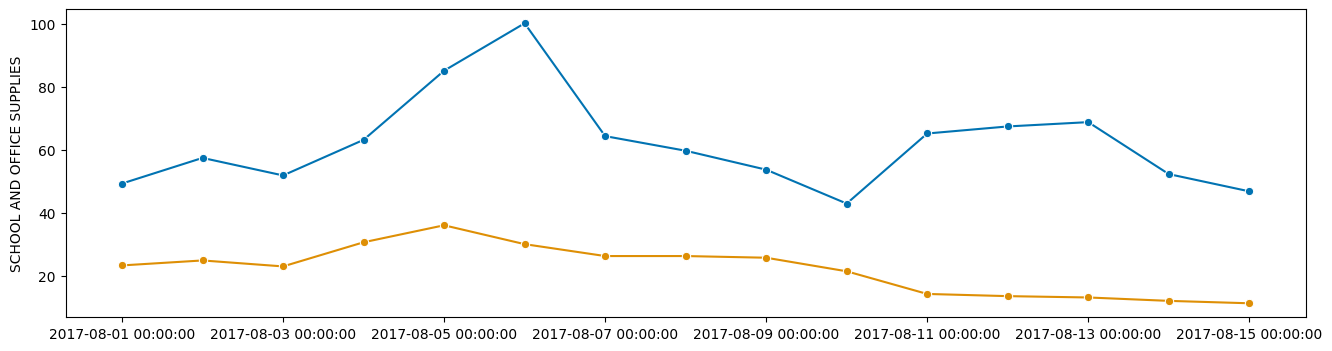

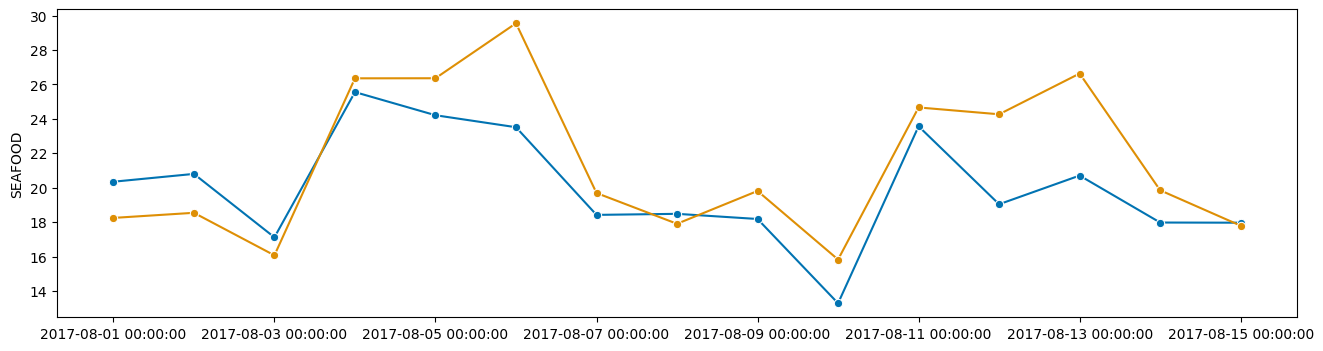

In [115]:
for col in y_test.columns:
    plot_series(y_test[col], y_pred_df[col])

In [164]:
test_stat, pvalue = diebold_mariano_test(y_pred,y_pred_df, y_test, 4)
#print(np.mean(test_stat))
#print(np.mean(pvalue))
print('Diebold-Mariano Test Statistic : ',np.mean(test_stat))
print('2 tailed test p-value : ', np.mean(pvalue))

Diebold-Mariano Test Statistic :  36.12321837399342
2 tailed test p-value :  0.0151827887020265


##### Interpreting the results
The predictions are definitely improving! We can see from the results of the Diebold-Mariano test that the difference in predictive accuracy from the original NaiveForecaster we tried and this tuned LGBM model is statistically significant at alpha = .05

The Null Hypothesis of the DM test states that there is no significant different in the accuracy of the two forecasts. Because the p-value is so low, we can reject the null hypothesis and conclude that these forecasts are significantly difference in their predictive accuracy. 